# Purpose: Produce graphs and run simple regressions

This code will load in the full data set and repeat the simple regressions and graphs we ran on the earlier set of data. Hopefully they are similar!!!!

In [7]:
import pandas as pd
import numpy as np
import pickle
from ipywidgets import FloatProgress
import matplotlib.pyplot as plt
import pandas as pd  # Import the package
import numpy as np
import statsmodels.api as sm
import re
import statsmodels.tsa.x13 as X13
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.dates as pltdates
import matplotlib.patches as mpatches
import matplotlib as matplotlib
import linearmodels as lm
import statsmodels.formula.api as smf
from linearmodels import PanelOLS
from linearmodels import IV2SLS
from linearmodels import IVGMM
from ipywidgets import FloatProgress
from IPython.display import display
import argparse
import os
import subprocess
from datetime import datetime
import scipy as scipy
import xlrd as xlrd
import country_converter as coco

from dotenv import dotenv_values, find_dotenv
# this looks for your configuration file and then reads it as a dictionary
config = dotenv_values(find_dotenv())

In [13]:
# Set parameters and paths

path_rawdata = os.path.abspath(os.path.join(os.getcwd(), '..', 'RawData')) + '/'
path_cleandata = os.path.abspath(os.path.join(os.getcwd(), '..', 'CleanData')) + '/'
path_saveFig = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures')) + '/'

path_cleandata = config["CLEANDATA"] + '/'
path_rawdata = os.path.abspath(config["RAWDATA"]) + '/'
path_ICIO = os.path.abspath(config["RAWDATA"]) + '/ICIO/'
path_invoicing = os.path.abspath(config["RAWDATA"]) + '/'

# Use new FX data
saveAppend_FX = '_TSimportShares_Taiwan'
saveAppend_FX ='_TSICIO'
#saveAppend_FX ='_ICIO_wICIO'

graphsSaveAppend = '_year'

In [14]:
df = pd.read_pickle(path_cleandata+'FullData'+saveAppend_FX+'.pkl')
df['cent_exp']=(df['cent_exp']-df['cent_exp'].mean())/df['cent_exp'].std()
# don't think df2 is used...
# df2 = pd.read_pickle(path_cleandata+'FullData'+'_NScode'+'.pkl')


In [15]:
df.groupby('year').count()['forwardspread']

year
1983      0
1984      0
1985      0
1986      0
1987      0
1988    204
1989    204
1990    256
1991    264
1992    264
1993    264
1994    264
1995    281
1996    294
1997    300
1998    301
1999    276
2000    285
2001    288
2002    288
2003    288
2004    288
2005    288
2006    370
2007    415
2008    431
2009    432
2010    432
2011    432
2012    432
2013    432
2014    432
2015    432
2016    432
2017    432
2018    424
2019    408
2020    408
2021    408
2022    372
2023     93
Name: forwardspread, dtype: int64

In [16]:
df_b = df.copy()

In [17]:
# remove Euro countries when in the Euro (as they all have the same currency returns)

df = df[df['Euro Indicator']==False]
df['Decade']=np.floor(df['year']/10)*10

# Add in UAE country name
df.loc[df['iso3']=='ARE','Country']='United Arab Emirates'

# keep only those countries in Richmond
Rlist = ['Australia','Austria','Belgium','Canada','Czech Republic','Denmark','EU','Finland','France','Germany'\
        'Greece','Hong Kong','Hungary','India','Indonesia','Ireland','Italy','Japan','Kuwait','Malaysia'\
        'Mexico','Netherlands','New Zealand','Norway','Philippines','Poland','Portugal','South Korea'\
        'Saudi Arabia','Singapore','South Africa','Spain','Sweden','Switzerland','Thailand','Turkey'\
        'United Arab Emirates','United Kingdom','United States']

df = df[df['Country'].isin(Rlist)]


# remove 0 sumShares as they are actually nans
df.loc[df['SumShares']<0.1,'SumShares']=np.nan
df.loc[df['SumShares_I']<0.01,'SumShares_I']=np.nan
df.loc[df['SumShares_X']<0.01,'SumShares_X']=np.nan
df.loc[df['SumShares_X_I']<0.01,'SumShares_X_I']=np.nan

# scale forward spread (noninal and real) to be annual units
df['forwardspread']=df['forwardspread']*1200
df['realfwdspread']=df['realfwdspread']*1200


## REMOVE ONCE EU CPI IS INCLUDED
df.loc[(df['Country']=='EU')&(df['cpi'].isnull()),'realfwdspread']=df.loc[(df['Country']=='EU')&(df['cpi'].isnull()),'forwardspread']-0.02/12

share = lambda x: x/x.sum()
df['NGDP_share'] = df.groupby(['year','month'])['gdp'].transform(share)

# remove the weird case where post 2018 EU GDP is the only one populated
df[df['NGDP_share']==1]=np.nan

removeList = ['Country', 'year', 'ISO2', 'imfcode','Euro Indicator', 'Decade']
cols = df.columns
cols = [i for i in cols if i not in removeList]


#### IMPORTANT SETTING ######
freq='year'

##############################

# Make sure that the groupby is over the same data for all variables
xvar='SumShares'
ex_xvar = 'SumShares_X'

#df.loc[df[xvar].isnull(),'forwardspread']=np.nan
#df.loc[df[xvar].isnull(),'realfwdspread']=np.nan
#df.loc[df[xvar].isnull(),'NGDP_share']=np.nan
#df.loc[df[xvar].isnull(),'cent_exp']=np.nan
if freq!='iso3':
    compressed = df.groupby(['Country',freq,'iso3'])[cols].mean().reset_index()
else:
    compressed = df.groupby(['Country',freq])[cols].mean().reset_index()



In [18]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

In [19]:
def plotScatter(xvar,yvar,df,x_name,y_name):
    fig,ax=plt.subplots(figsize=(15,20))
    ax.scatter(df[xvar],df[yvar])
    ax.plot(df[xvar],df[xvar]*0,'k')

    #plt.xlabel(x_name)
    plt.ylabel(y_name)

    for i,txt in enumerate(df['iso3']):
        if (df[xvar].notnull()[i]==True)&(df[yvar].notnull()[i]==True):
            x=df[xvar][i]
            y=df[yvar][i]
            ax.annotate(txt,(x,y))

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


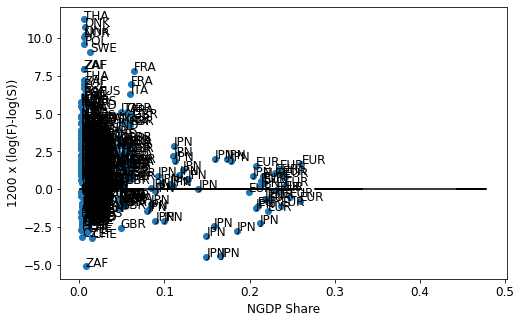

In [20]:
fig,ax=plt.subplots(figsize=(8,5))
ax.scatter(compressed['NGDP_share'],compressed['realfwdspread'])
ax.plot(compressed['NGDP_share'],compressed['NGDP_share']*0,'k')

plt.xlabel("NGDP Share")
plt.ylabel("1200 x (log(F)-log(S))")

for i,txt in enumerate(compressed['iso3']):
    if (compressed['NGDP_share'].notnull()[i]==True)&(compressed['realfwdspread'].notnull()[i]==True):
        x=compressed['NGDP_share'][i]
        y=compressed['realfwdspread'][i]
        ax.annotate(txt,(x,y))

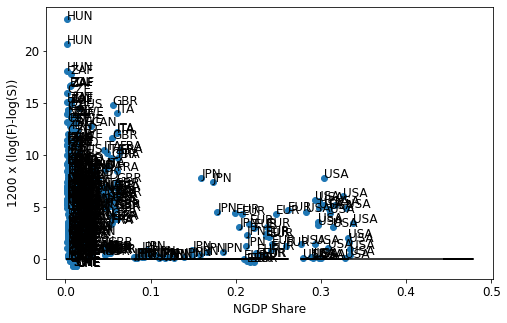

In [21]:
fig,ax=plt.subplots(figsize=(8,5))
ax.scatter(compressed['NGDP_share'],compressed['shortterm'])
ax.plot(compressed['NGDP_share'],compressed['NGDP_share']*0,'k')

plt.xlabel("NGDP Share")
plt.ylabel("1200 x (log(F)-log(S))")

for i,txt in enumerate(compressed['iso3']):
    if (compressed['NGDP_share'].notnull()[i]==True)&(compressed['shortterm'].notnull()[i]==True):
        x=compressed['NGDP_share'][i]
        y=compressed['shortterm'][i]
        ax.annotate(txt,(x,y))

(0.0, 0.4)

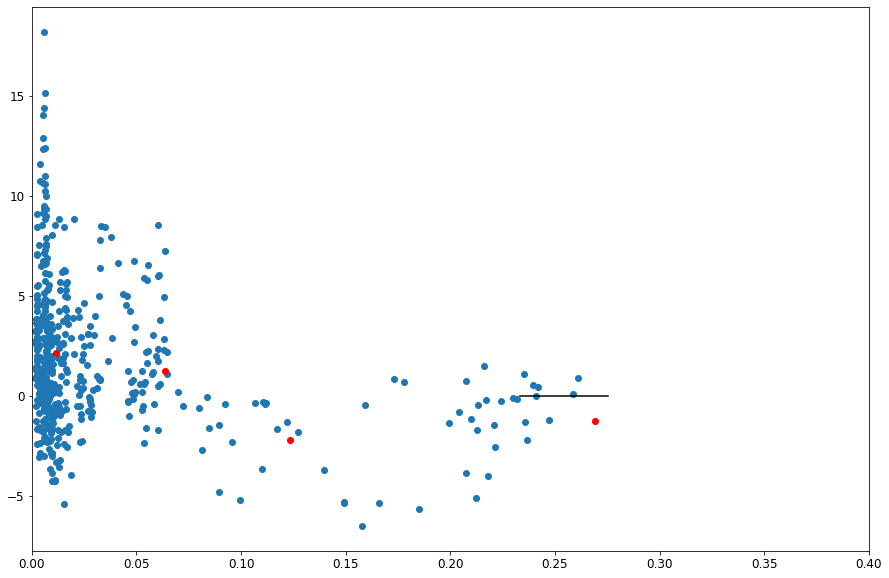

In [22]:
yvar='forwardspread'
compressed.loc[compressed['NGDP_share']<0.05,'quartile']=1
compressed.loc[(compressed['NGDP_share']>=0.05)&(compressed['NGDP_share']<0.1),'quartile']=2
compressed.loc[(compressed['NGDP_share']>=0.1)&(compressed['NGDP_share']<0.15),'quartile']=3
compressed.loc[compressed['NGDP_share']>0.15,'quartile']=4

compressed2 = compressed.groupby(['quartile']).mean()

fig,ax=plt.subplots(figsize=(15,10))
ax.scatter(compressed['NGDP_share'],compressed[yvar])
ax.plot(compressed[xvar],compressed['NGDP_share']*0,'k')
ax.scatter(compressed2['NGDP_share'],compressed2[yvar],color='red')
ax.plot(compressed2[xvar],compressed2['NGDP_share']*0,'k')

plt.xlim([0,0.4])

(0.0, 0.4)

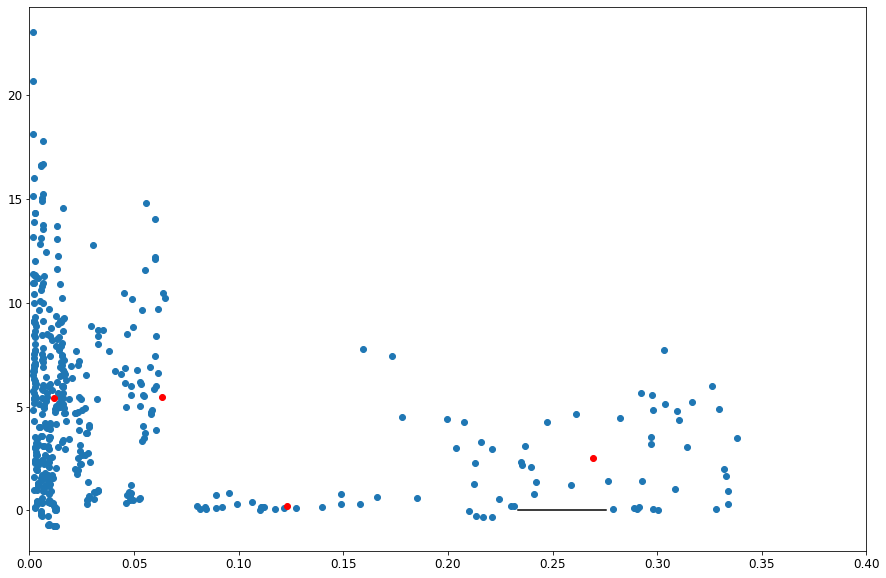

In [23]:
yvar='shortterm'
compressed.loc[compressed['NGDP_share']<0.05,'quartile']=1
compressed.loc[(compressed['NGDP_share']>=0.05)&(compressed['NGDP_share']<0.1),'quartile']=2
compressed.loc[(compressed['NGDP_share']>=0.1)&(compressed['NGDP_share']<0.15),'quartile']=3
compressed.loc[compressed['NGDP_share']>0.15,'quartile']=4

compressed2 = compressed.groupby(['quartile']).mean()

fig,ax=plt.subplots(figsize=(15,10))
ax.scatter(compressed['NGDP_share'],compressed[yvar])
ax.plot(compressed[xvar],compressed['NGDP_share']*0,'k')
ax.scatter(compressed2['NGDP_share'],compressed2[yvar],color='red')
ax.plot(compressed2[xvar],compressed2['NGDP_share']*0,'k')

plt.xlim([0,0.4])

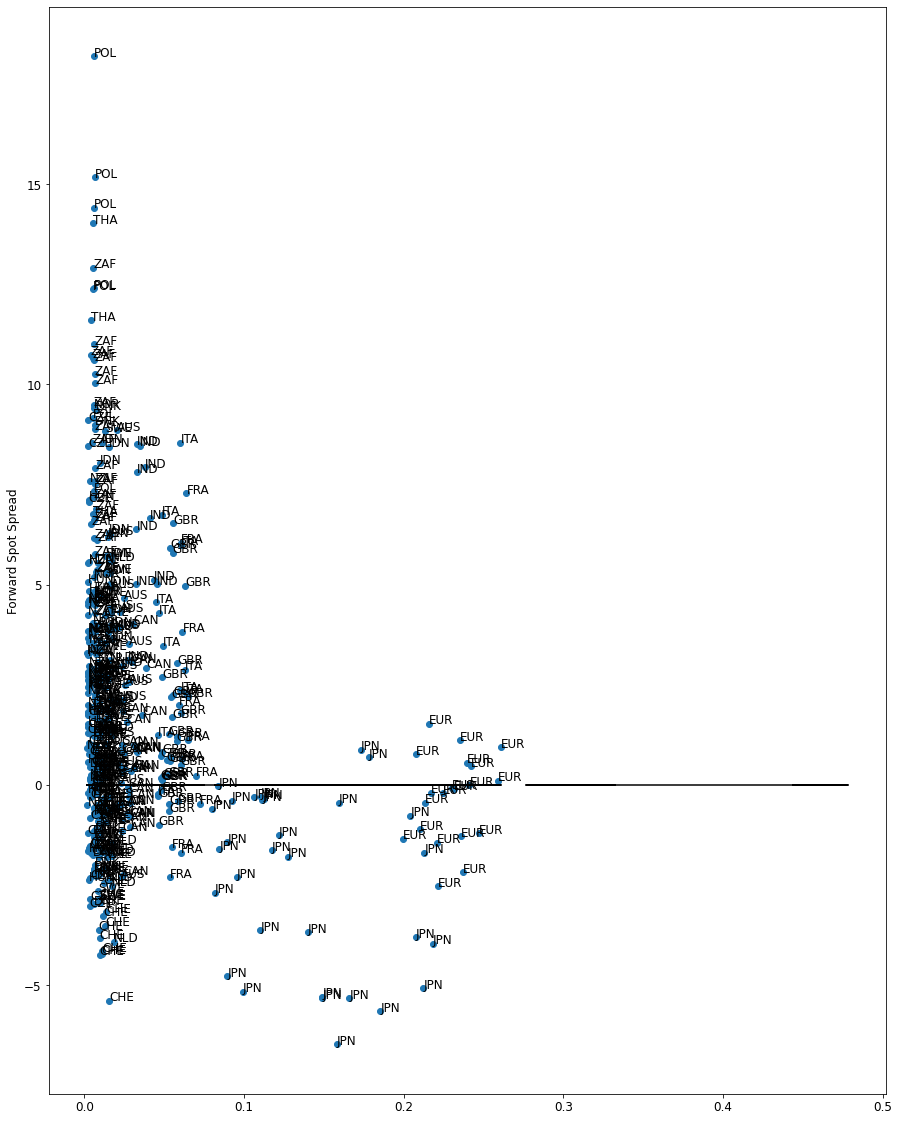

In [24]:
plotScatter('NGDP_share','forwardspread',compressed,"NGDP Share","Forward Spot Spread")
# plt.savefig(path_saveFig+'size_fwd'+graphsSaveAppend+'.pdf')

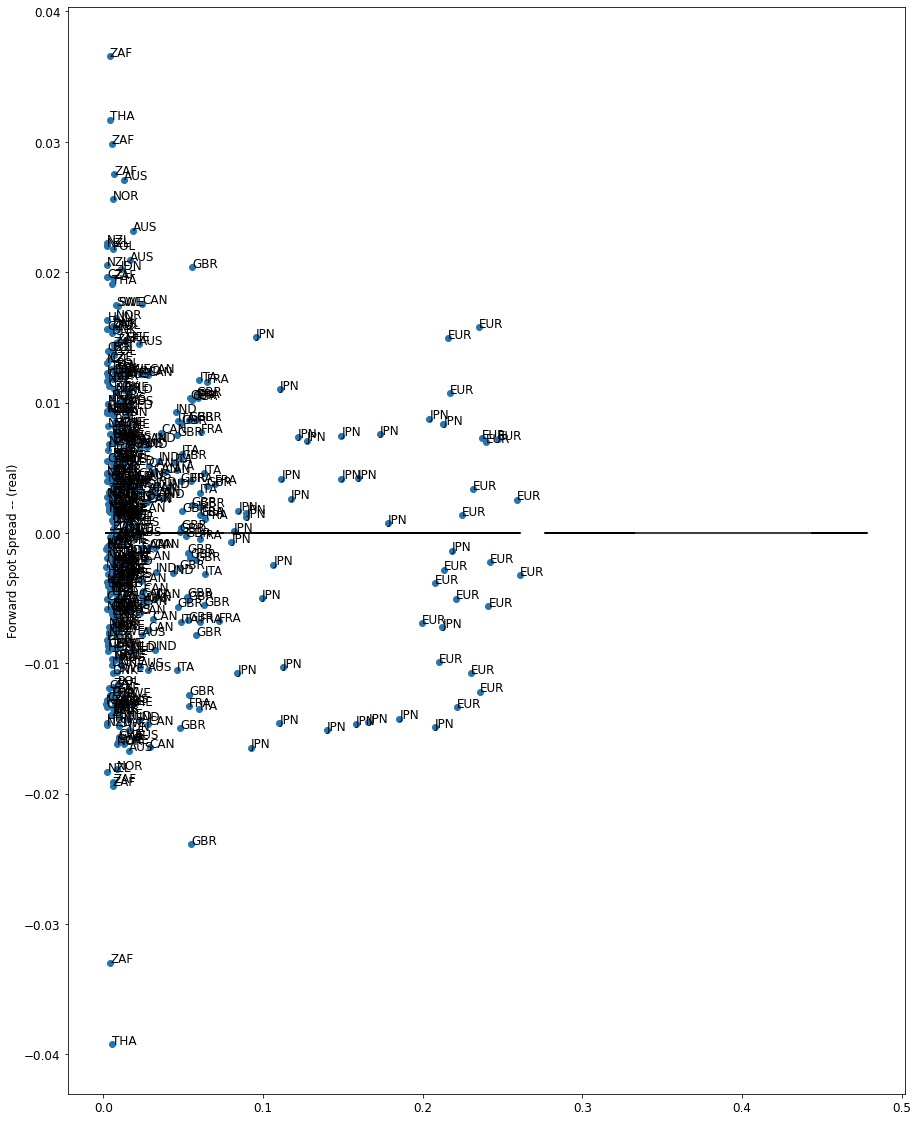

In [25]:
plotScatter('NGDP_share','logrx',compressed,"NGDP Share","Forward Spot Spread -- (real)")
# plt.savefig(path_saveFig+'size_rp'+graphsSaveAppend+'.pdf')

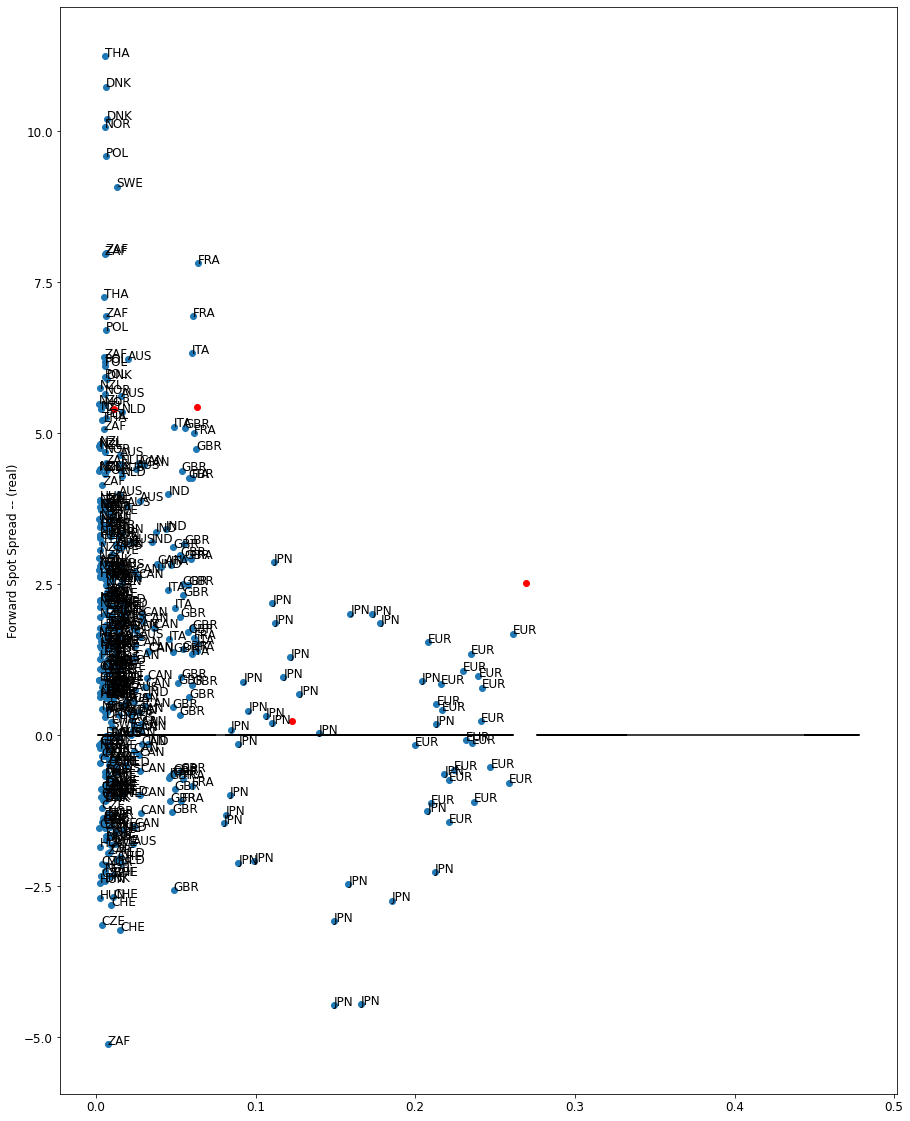

In [26]:
plotScatter('NGDP_share','realfwdspread',compressed,"NGDP Share","Forward Spot Spread -- (real)")
ax=plt.gca()
ax.scatter(compressed2['NGDP_share'],compressed2[yvar],color='red')

# plt.savefig(path_saveFig+'size_fwd_real'+graphsSaveAppend+'.pdf')

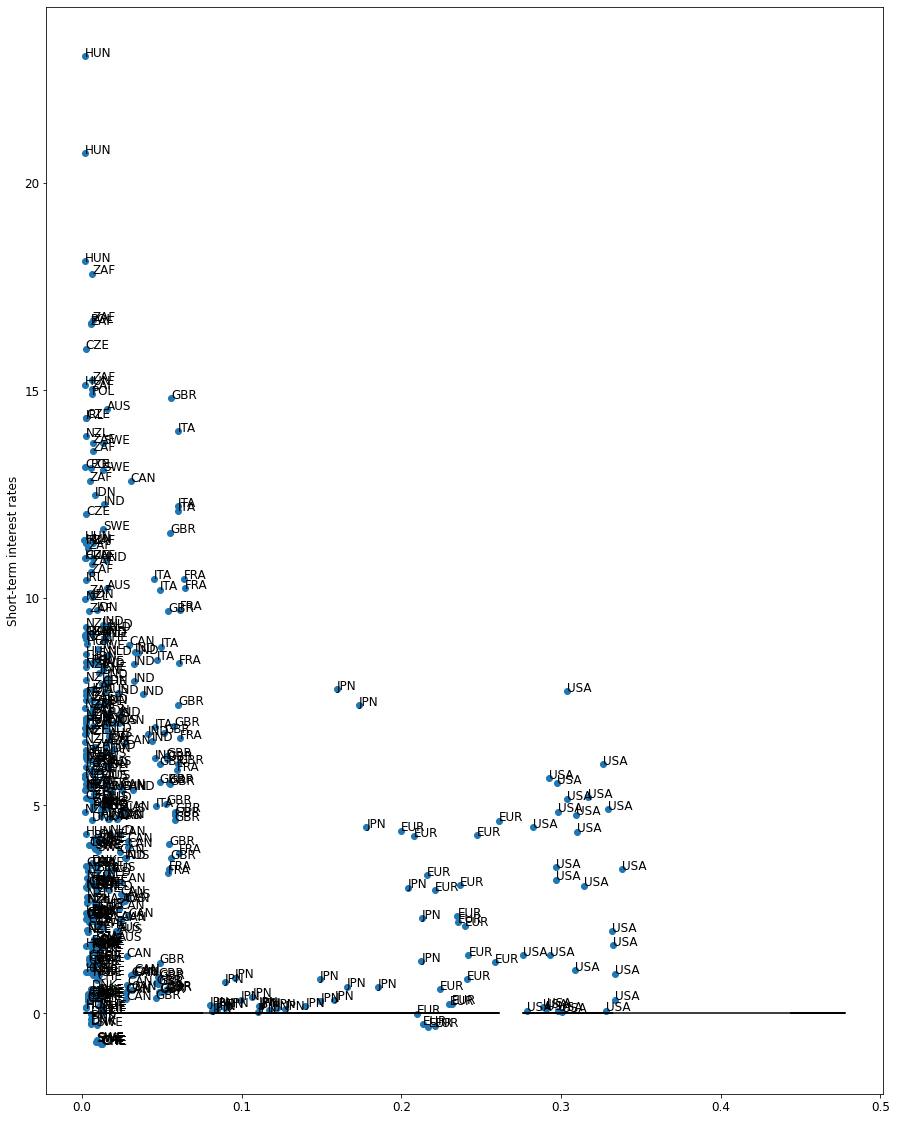

In [27]:
plotScatter('NGDP_share','shortterm',compressed,"NGDP Share","Short-term interest rates")
# plt.savefig(path_saveFig+'size_rates'+graphsSaveAppend+'.pdf')

(0.0, 0.4)

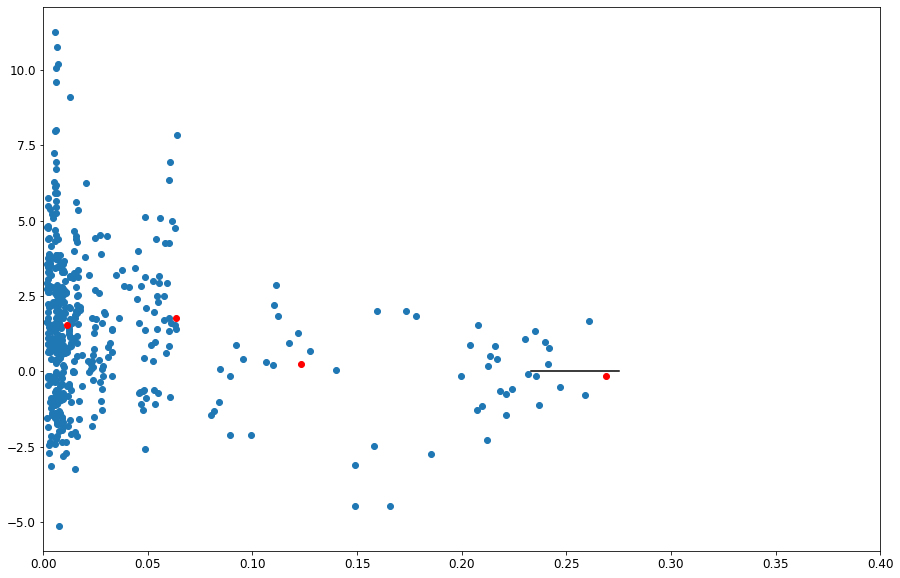

In [28]:
yvar='realfwdspread'
compressed.loc[compressed['NGDP_share']<0.05,'quartile']=1
compressed.loc[(compressed['NGDP_share']>=0.05)&(compressed['NGDP_share']<0.1),'quartile']=2
compressed.loc[(compressed['NGDP_share']>=0.1)&(compressed['NGDP_share']<0.15),'quartile']=3
compressed.loc[compressed['NGDP_share']>0.15,'quartile']=4

compressed2 = compressed.groupby(['quartile']).mean()

fig,ax=plt.subplots(figsize=(15,10))
ax.scatter(compressed['NGDP_share'],compressed[yvar])
ax.plot(compressed[xvar],compressed['NGDP_share']*0,'k')
ax.scatter(compressed2['NGDP_share'],compressed2[yvar],color='red')
ax.plot(compressed2[xvar],compressed2['NGDP_share']*0,'k')

plt.xlim([0,0.4])


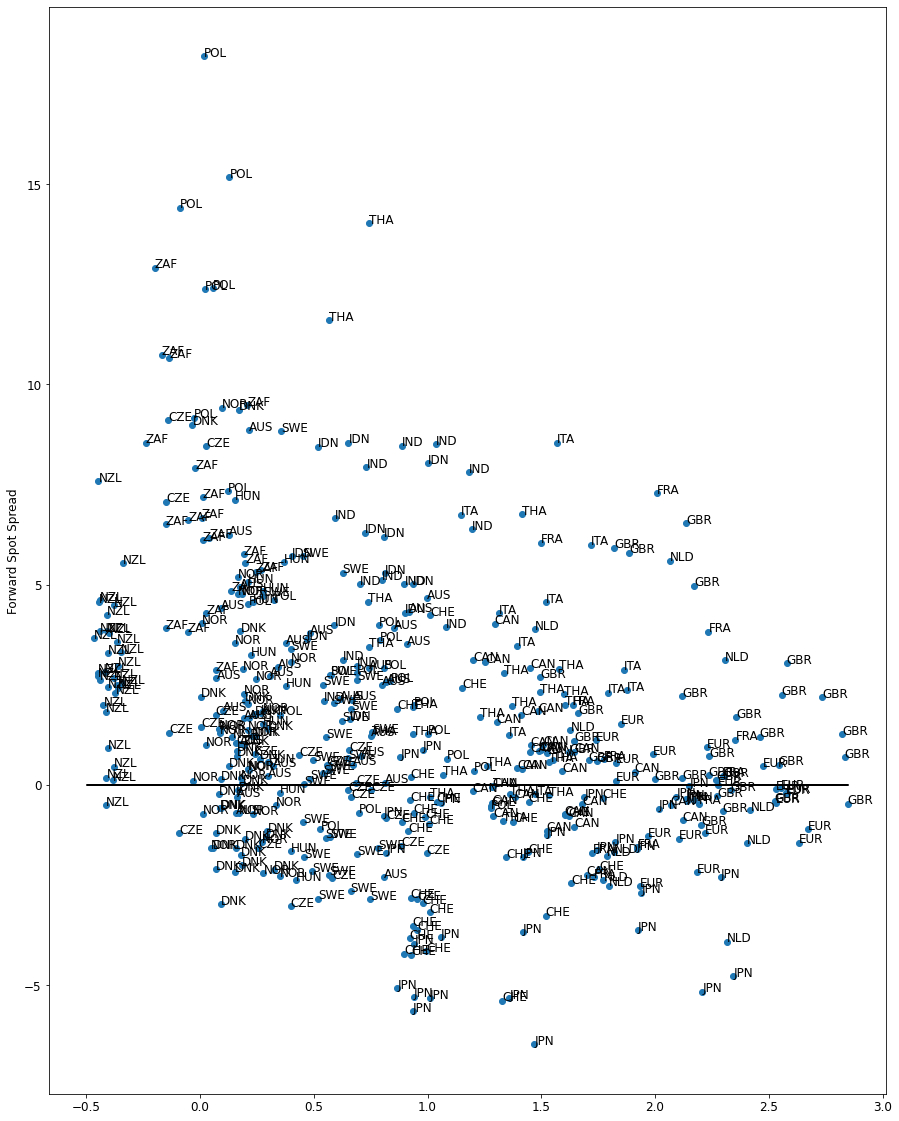

In [29]:
plotScatter('cent_exp','forwardspread',compressed,"Centrality","Forward Spot Spread")
# plt.savefig(path_saveFig+'centrality_fwd'+graphsSaveAppend+'.pdf')

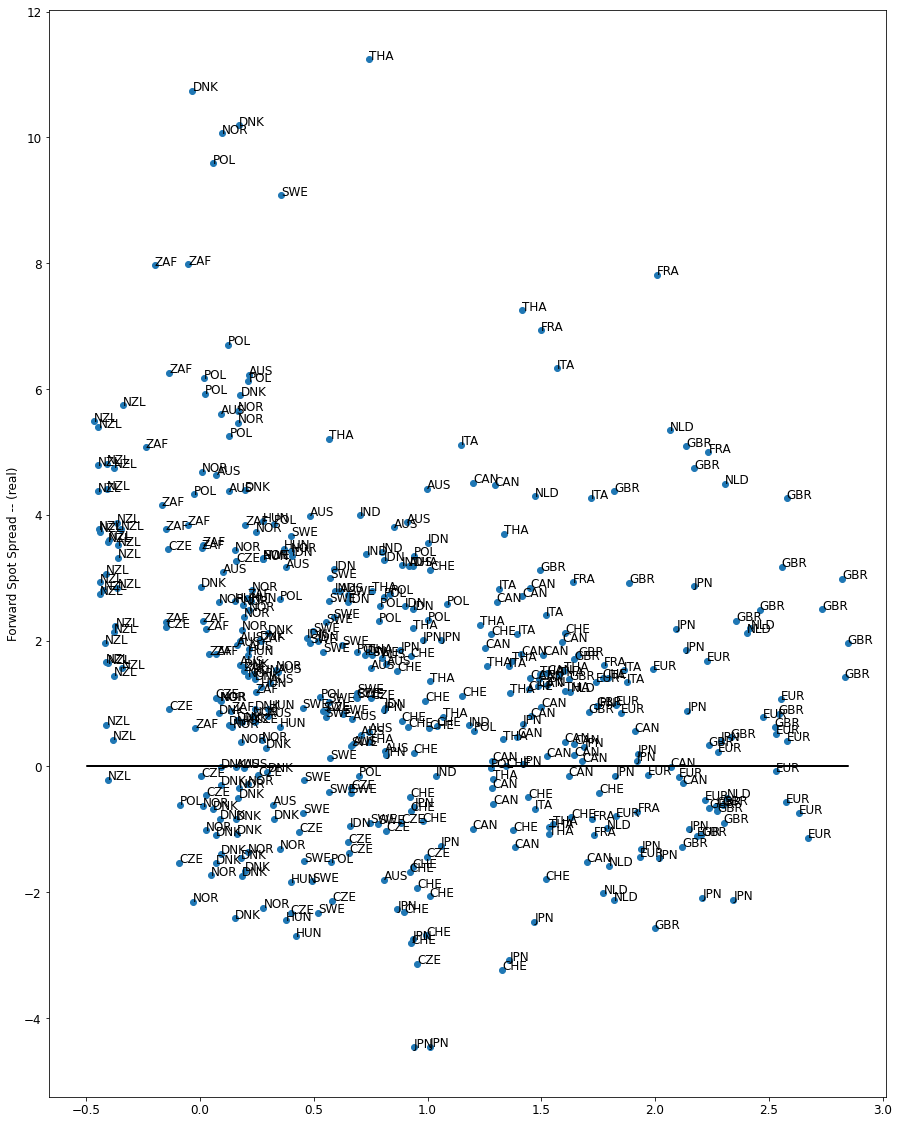

In [30]:
plotScatter('cent_exp','realfwdspread',compressed,"Centrality","Forward Spot Spread -- (real)")
# plt.savefig(path_saveFig+'centrality_fwd_real'+graphsSaveAppend+'.pdf')

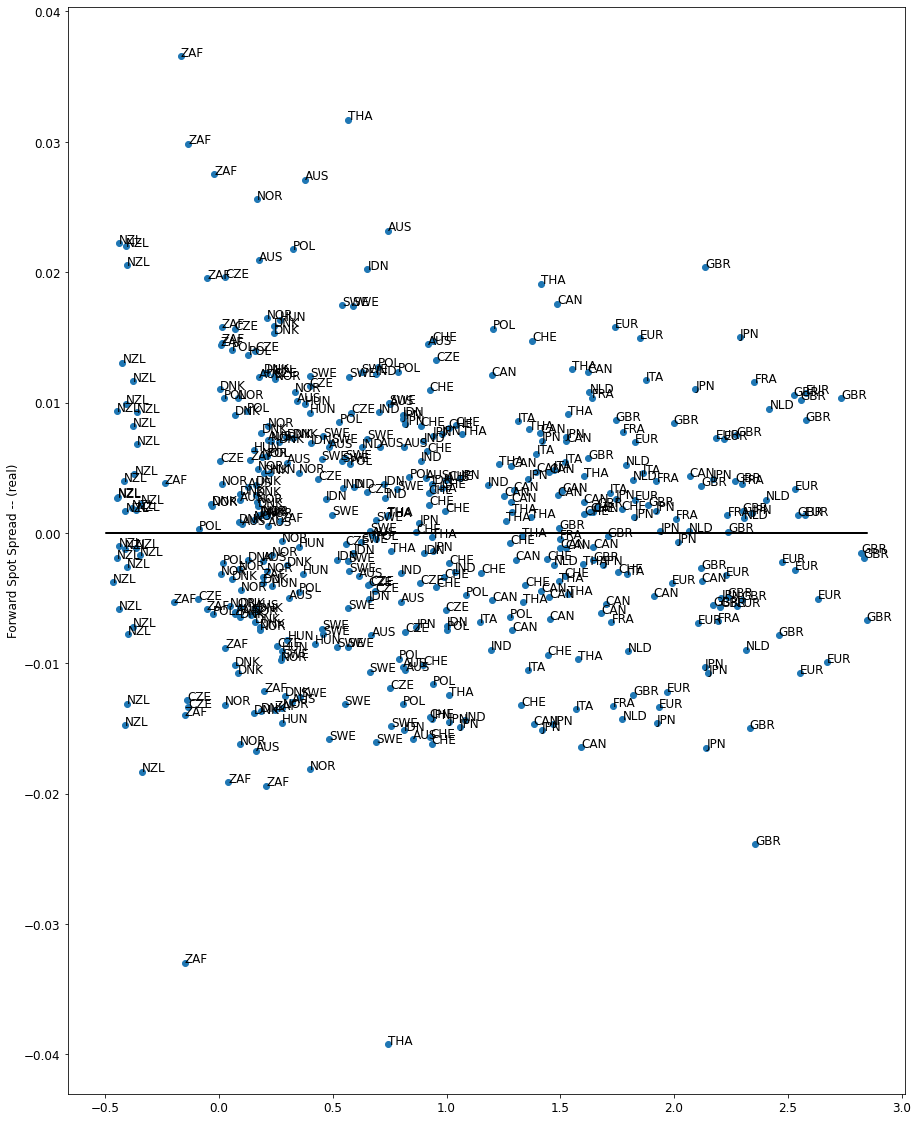

In [31]:
plotScatter('cent_exp','logrx',compressed,"Centrality","Forward Spot Spread -- (real)")
# plt.savefig(path_saveFig+'centrality_rp'+graphsSaveAppend+'.pdf')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/Nick/Desktop/github testing/figures/centrality_rates_year.pdf'

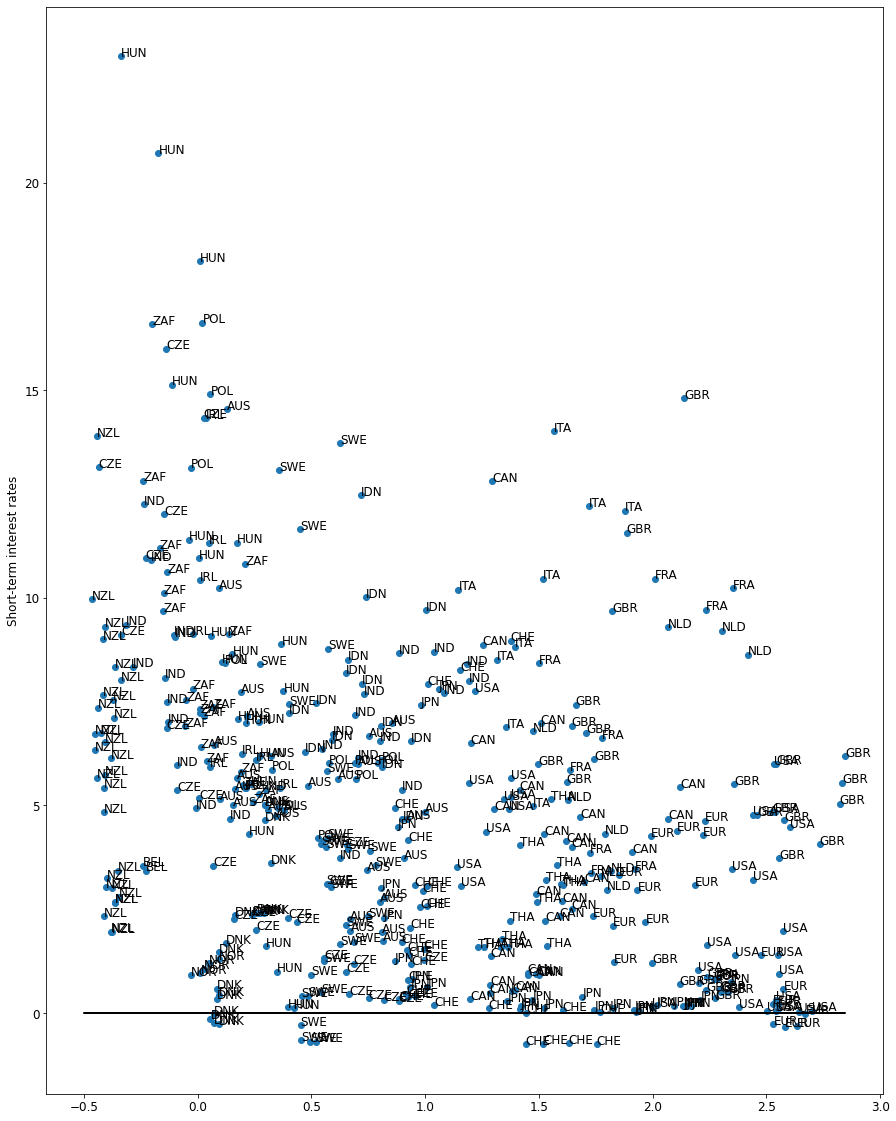

In [32]:
plotScatter('cent_exp','shortterm',compressed,"Centrality","Short-term interest rates")
plt.savefig(path_saveFig+'centrality_rates'+graphsSaveAppend+'.pdf')

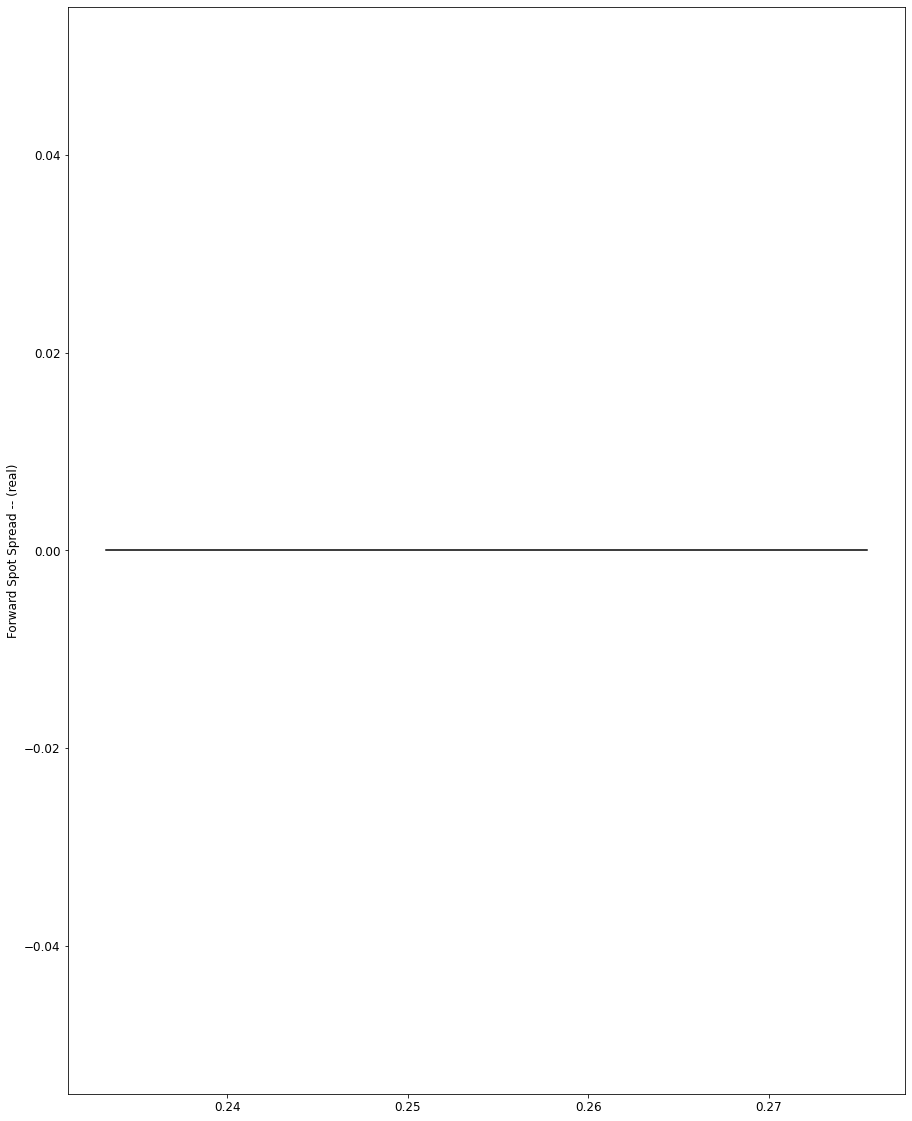

In [ ]:
plotScatter('SumShares','realfwdspread',compressed,"Currency Concentration","Forward Spot Spread -- (real)")
# plt.savefig(path_saveFig+'concentration_fwd_real'+graphsSaveAppend+'.pdf')

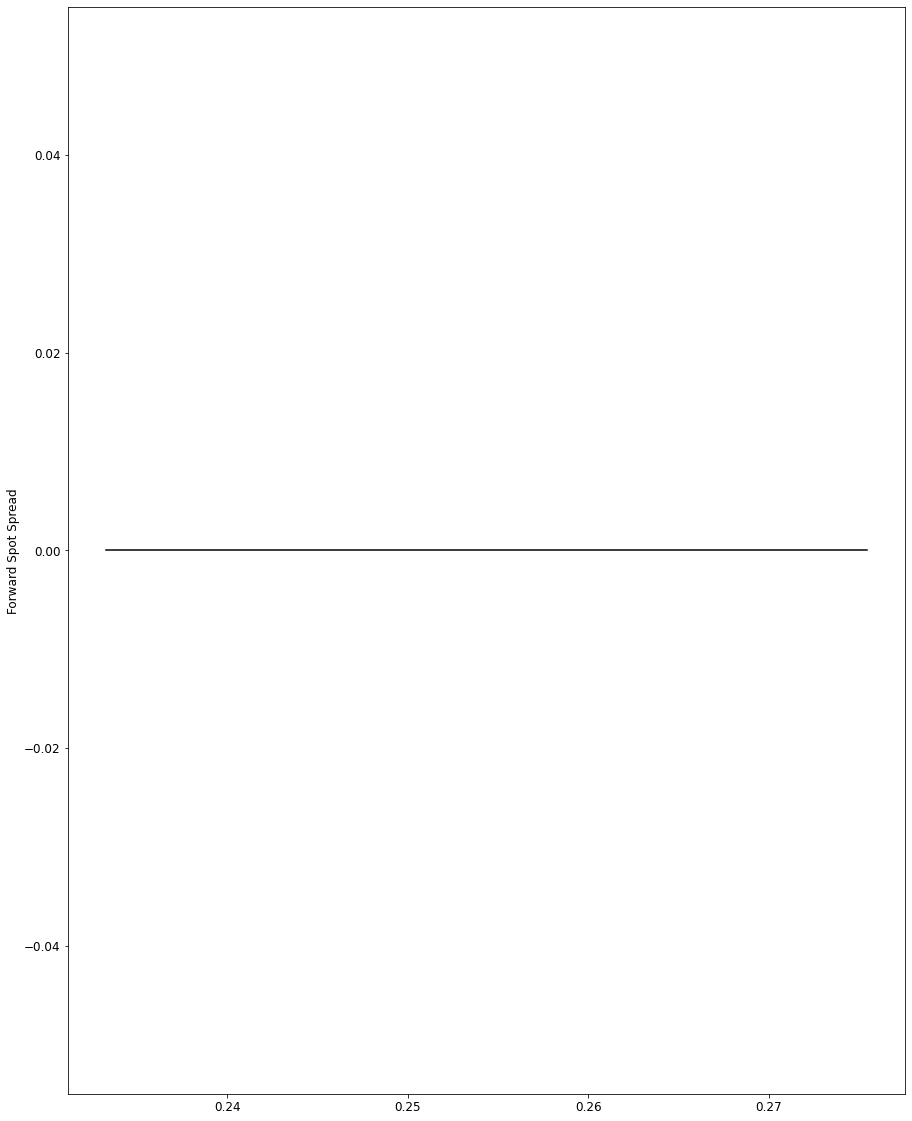

In [ ]:
plotScatter('SumShares','forwardspread',compressed,"Currency Concentration","Forward Spot Spread")
# plt.savefig(path_saveFig+'concentration_fwd'+graphsSaveAppend+'.pdf')

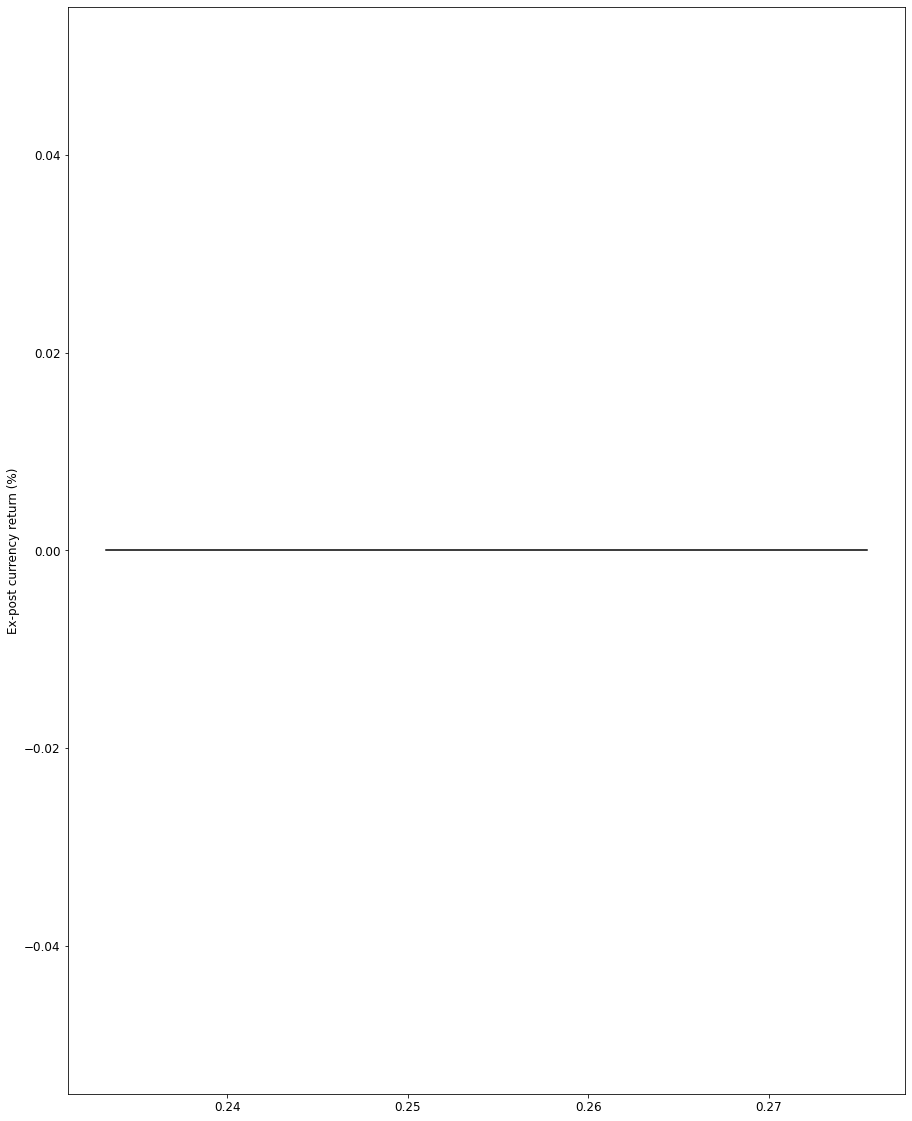

In [ ]:
plotScatter('SumShares','logrx',compressed,"Currency Concentration","Ex-post currency return (%)")
# plt.savefig(path_saveFig+'concentration_rp'+graphsSaveAppend+'.pdf')

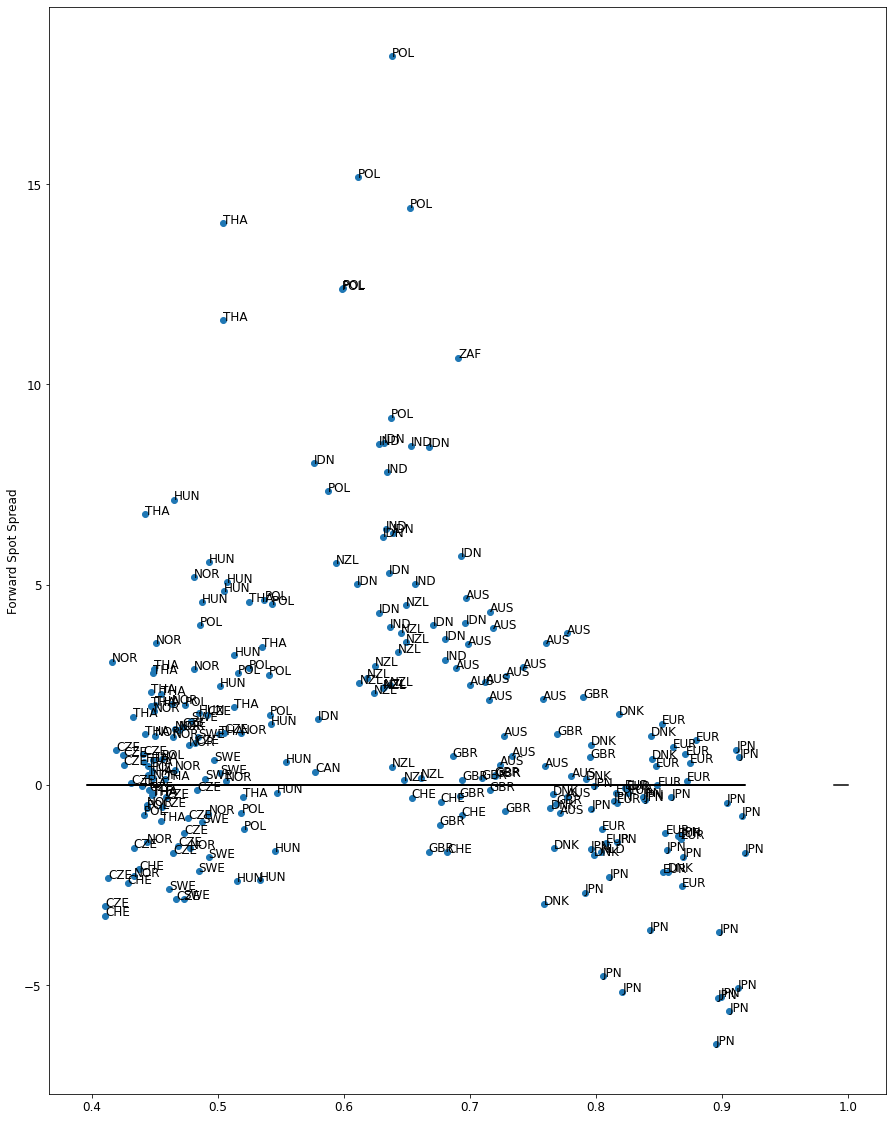

In [ ]:
plotScatter('SumShares_X','forwardspread',compressed,"Currency Concentration","Forward Spot Spread")
# plt.savefig(path_saveFig+'concentration_X_fwd'+graphsSaveAppend+'.pdf')

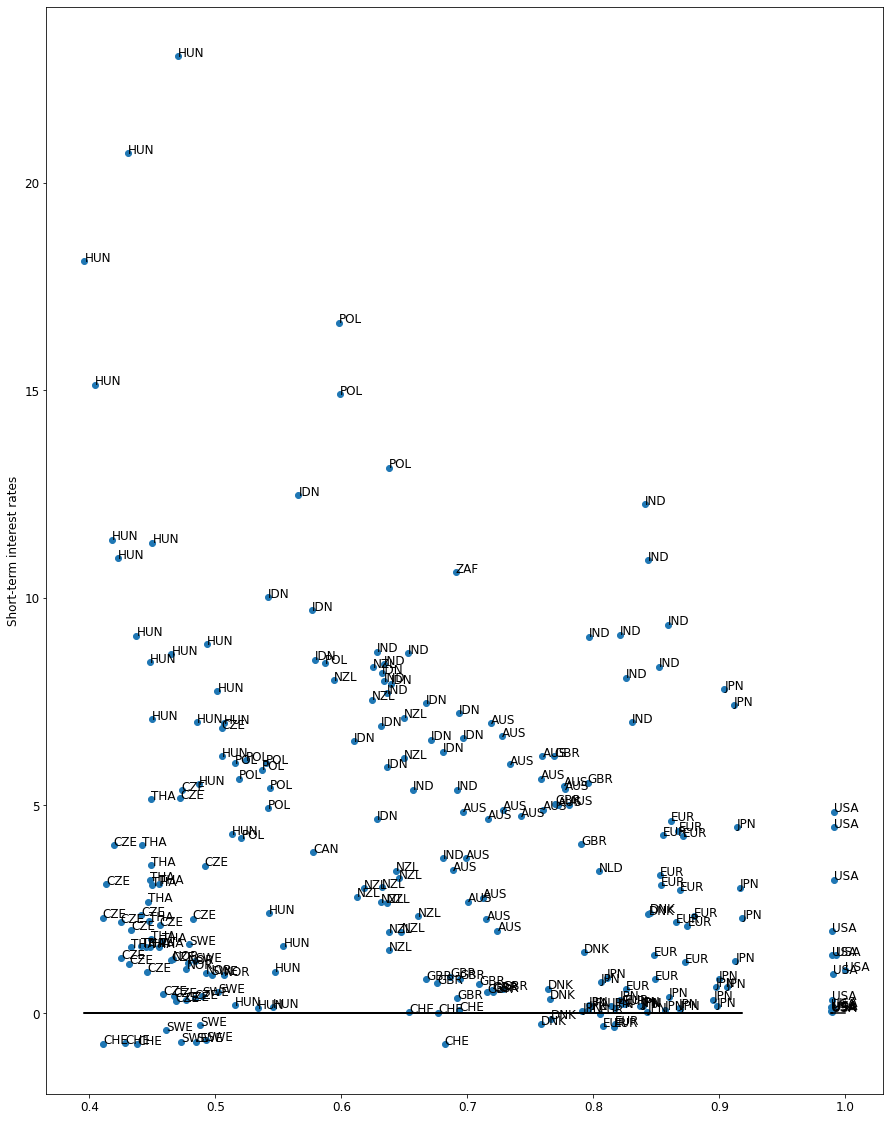

In [ ]:
plotScatter('SumShares_X','shortterm',compressed,"Currency Concentration","Short-term interest rates")
# plt.savefig(path_saveFig+'concentration_rates'+graphsSaveAppend+'.pdf')

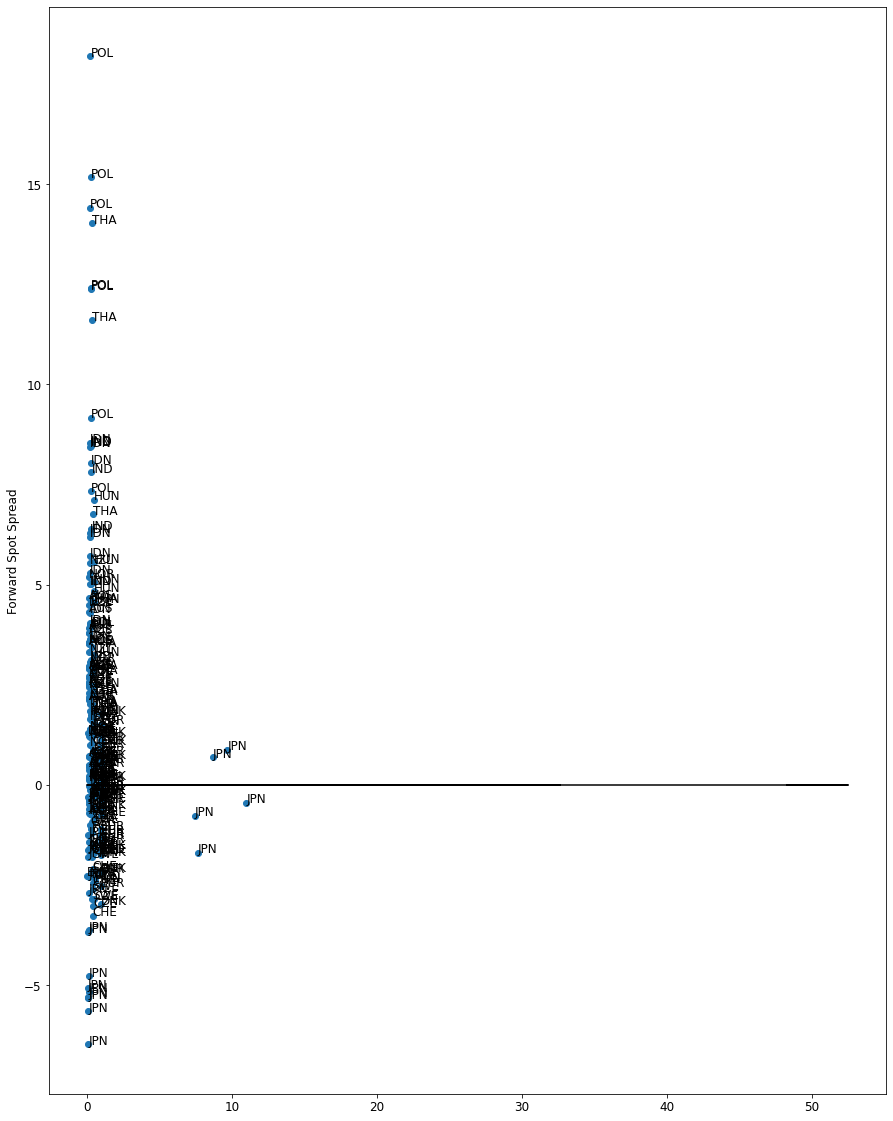

In [ ]:
compressed['USD_EUR_share'] = compressed['Import USD']+compressed['Import EUR']

plotScatter('USD_EUR_share','forwardspread',compressed,"USD + EUR Share of Consumption","Forward Spot Spread")
# plt.savefig(path_saveFig+'USD_EUR_fwd'+graphsSaveAppend+'.pdf')

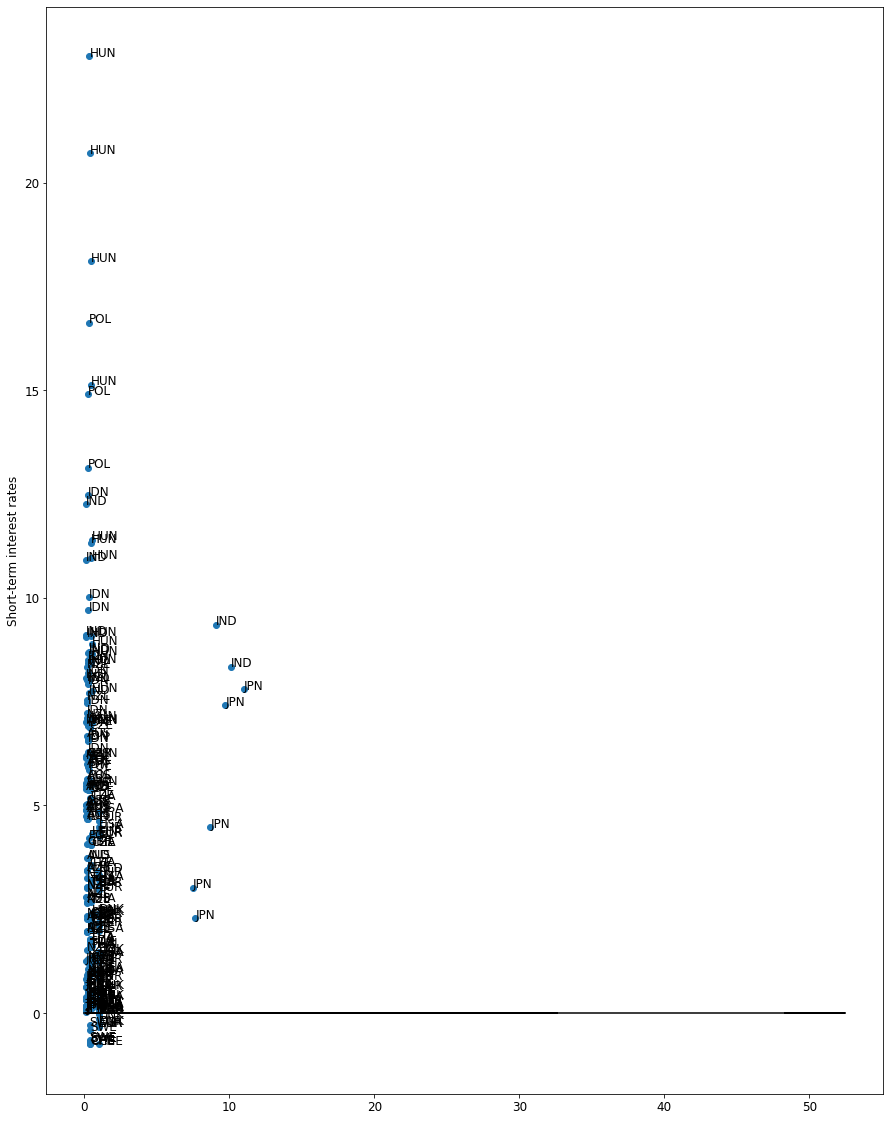

In [ ]:
compressed['USD_EUR_share'] = compressed['Import USD']+compressed['Import EUR']

plotScatter('USD_EUR_share','shortterm',compressed,"USD + EUR Share of Consumption","Short-term interest rates")
plt.savefig(path_saveFig+'USD_EUR_rates'+graphsSaveAppend+'.pdf')

# Regressions!

In [ ]:

#freq = 'year'

yvar = 'forwardspread'
yvar2 = 'shortterm'
#xvar = 'SumShares_I'


compressed_reg_other =  df.groupby(['iso3',freq])[cols].mean().reset_index()

compressed['constant']=1

# Make sure that the groupby is over the same data for all variables
df.loc[df[xvar].isnull(),yvar]=np.nan
df.loc[df[xvar].isnull(),'NGDP_share']=np.nan
df.loc[df[xvar].isnull(),'cent_exp']=np.nan



compressed_reg = df.groupby(['iso3',freq])[cols].mean().reset_index()

compressed_reg['constant']=1

zscore = lambda x: (x-x.mean())/x.std() 
compressed['cent_exp'] = zscore(compressed['cent_exp'])
compressed['NGDP_share'] = zscore(compressed['NGDP_share'])
                    
toreg = compressed_reg[['iso3',freq,yvar, yvar2, 'constant','NGDP_share','cent_exp',xvar,ex_xvar]]
#toreg = toreg[~toreg['Country'].isin(['India','Russia','Indonesia','Iceland','Hungary','Czech Republic'])]
#toreg = toreg[~toreg['Country'].isin(['Switzerland','India','Russia','Indonesia','Iceland','Hungary','Czech Republic'])]
#toreg = toreg[~toreg['Country'].isin(['Thailand','Poland'])]

In [ ]:
# differences in data

look_at_nans = toreg.groupby(['iso3']).mean().reset_index()

display(look_at_nans.loc[(look_at_nans['forwardspread'].notnull()) & (look_at_nans['shortterm'].isna())])

display(look_at_nans.loc[look_at_nans['forwardspread'].isna()])

display(look_at_nans.loc[look_at_nans['shortterm'].isna()])

,iso3,year,forwardspread,shortterm,constant,NGDP_share,cent_exp,SumShares,SumShares_X


,iso3,year,forwardspread,shortterm,constant,NGDP_share,cent_exp,SumShares,SumShares_X
0,AUS,2003.000000,NaN,4.859687,1.0,NaN,NaN,NaN,0.734313
1,AUT,1990.500000,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2,BEL,1990.500000,NaN,6.366481,1.0,NaN,NaN,NaN,NaN
3,CAN,2003.000000,NaN,3.196250,1.0,NaN,NaN,NaN,0.577459
4,CHE,2003.000000,NaN,1.883857,1.0,NaN,NaN,NaN,0.569097
5,CZE,2003.000000,NaN,4.598574,1.0,NaN,NaN,NaN,0.454410
6,DNK,2003.000000,NaN,1.351378,1.0,NaN,NaN,NaN,0.800523
7,ESP,1990.500000,NaN,NaN,1.0,NaN,NaN,NaN,0.885720
8,EUR,2001.108108,NaN,1.852537,1.0,NaN,NaN,NaN,0.846911
9,FIN,1990.500000,NaN,NaN,1.0,NaN,NaN,NaN,NaN


,iso3,year,forwardspread,shortterm,constant,NGDP_share,cent_exp,SumShares,SumShares_X
1,AUT,1990.5,NaN,NaN,1.0,NaN,NaN,NaN,NaN
7,ESP,1990.5,NaN,NaN,1.0,NaN,NaN,NaN,0.88572
9,FIN,1990.5,NaN,NaN,1.0,NaN,NaN,NaN,NaN
22,PRT,1990.5,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [ ]:
compressed_reg_other = compressed.set_index(['iso3',freq])
restmp  = PanelOLS(compressed_reg_other[yvar],compressed_reg_other[['constant','NGDP_share','cent_exp']],entity_effects=False,time_effects=False)
res7 = restmp.fit(cov_type='clustered',cluster_entity=False)
restmp  = PanelOLS(compressed_reg_other[yvar2],compressed_reg_other[['constant','NGDP_share','cent_exp']],entity_effects=False,time_effects=False)
res7_y2 = restmp.fit(cov_type='clustered',cluster_entity=False)

mod=sm.OLS(toreg[yvar],toreg[['constant','NGDP_share','cent_exp',xvar,ex_xvar]],missing = 'drop')
res=mod.fit(cov_type='HC3')
mod=sm.OLS(toreg[yvar2],toreg[['constant','NGDP_share','cent_exp',xvar,ex_xvar]],missing = 'drop')
res_y2 = mod.fit(cov_type='HC3')

toreg = toreg.set_index(['iso3',freq])

mod =PanelOLS(toreg[yvar],toreg[['constant','NGDP_share','cent_exp',xvar,ex_xvar]],entity_effects=False,time_effects=True)
res = mod.fit(cov_type='clustered',cluster_entity=False)
mod =PanelOLS(toreg[yvar2],toreg[['constant','NGDP_share','cent_exp',xvar,ex_xvar]],entity_effects=False,time_effects=True)
res_y2 = mod.fit(cov_type='clustered',cluster_entity=False)

mod =PanelOLS(toreg[yvar],toreg[['constant','NGDP_share','cent_exp',xvar]],entity_effects=False,time_effects=True)
res2 = mod.fit(cov_type='clustered',cluster_entity=False)
mod =PanelOLS(toreg[yvar2],toreg[['constant','NGDP_share','cent_exp',xvar]],entity_effects=False,time_effects=True)
res2_y2 = mod.fit(cov_type='clustered',cluster_entity=False)

mod =PanelOLS(toreg[yvar],toreg[['constant',xvar]],entity_effects=False,time_effects=True)
res3 = mod.fit(cov_type='clustered',cluster_entity=False)
mod =PanelOLS(toreg[yvar2],toreg[['constant',xvar]],entity_effects=False,time_effects=True)
res3_y2 = mod.fit(cov_type='clustered',cluster_entity=False)

mod =PanelOLS(toreg[yvar],toreg[['constant','NGDP_share','cent_exp']],entity_effects=False,time_effects=True)
res4 = mod.fit(cov_type='clustered',cluster_entity=False)
mod =PanelOLS(toreg[yvar2],toreg[['constant','NGDP_share','cent_exp']],entity_effects=False,time_effects=True)
res4_y2 = mod.fit(cov_type='clustered',cluster_entity=False)

mod =PanelOLS(toreg[yvar],toreg[['constant','NGDP_share']],entity_effects=False,time_effects=True)
res5 = mod.fit(cov_type='clustered',cluster_entity=False)
mod =PanelOLS(toreg[yvar2],toreg[['constant','NGDP_share']],entity_effects=False,time_effects=True)
res5_y2 = mod.fit(cov_type='clustered',cluster_entity=False)

mod =PanelOLS(toreg[yvar],toreg[['constant','cent_exp']],entity_effects=False,time_effects=True)
res6 = mod.fit(cov_type='clustered',cluster_entity=False)
mod =PanelOLS(toreg[yvar2],toreg[['constant','cent_exp']],entity_effects=False,time_effects=True)
res6_y2 = mod.fit(cov_type='clustered',cluster_entity=False)

/opt/anaconda3/lib/python3.9/site-packages/linearmodels/panel/model.py:1183: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/opt/anaconda3/lib/python3.9/site-packages/linearmodels/panel/model.py:1183: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
#code with example output -- python to latex

def create_latex_table(regression_objects, rhs_variables_names, lhs_variable, filepath, toggle):
    '''
    create latex table that showcases regression output(s).
    
    Paramaters:
        - regression_objects (list of regression objects): regression output -- the coefficient and standard error associated with each rhs_variable.
        - rhs_variables (list of strings): names of independent variables (rhs variables) in the regression 
        - lhs_variable (string): name of dependent variable (lhs variable) in the regression
        - filepath (string): path and file name where the resulting LaTeX table (.tex file) will be saved
        - toggle (boolean): whether the Latex file has opening and closing arguments
        
    '''
    column_data = []
    for i in range(len(regression_objects)):
        coefficient = []
        standard_error = []
        t_stat_value = []
        p_value = []
        rhs_variables = []
        number_of_observations = 0
        included_effects = []
        if str(type(regression_objects[i])) == "<class 'linearmodels.panel.results.PanelEffectsResults'>":
            coefficient = regression_objects[i].params[1:]
            standard_error = regression_objects[i].std_errors[1:]
            t_stat_value = regression_objects[i].tstats[1:]
            p_value = regression_objects[i].pvalues[1:]
            rhs_variables = list(regression_objects[i].params.keys())[1:]
            number_of_observations = regression_objects[i].nobs
            included_effects = regression_objects[i].included_effects
        else:
            coefficient = regression_objects[i].params[1:] 
            standard_error = regression_objects[i].bse[1:] 
            t_stat_value = regression_objects[i].tvalues[1:] 
            p_value = regression_objects[i].pvalues[1:] 
            rhs_variables = regression_objects[i].model.exog_names[1:]
            number_of_observations = regression_objects[i].nobs 
            included_effects = []
            
        column_data.append({"coefficient": coefficient, "standard_error": standard_error, "p_value": p_value, "rhs_variables": rhs_variables, "N": number_of_observations, "included_effects": included_effects})

        row_data = {}

        for column in column_data:
            rhs_variables = column["rhs_variables"]
            for rhs in rhs_variables:
                if rhs not in row_data.keys():
                    row_data[rhs] = []

        for rhs_variable in row_data.keys():
            for column in column_data:
                if rhs_variable in column["rhs_variables"]:
                    index = column["rhs_variables"].index(rhs_variable)
                    row_data[rhs_variable].append({"coefficient": column["coefficient"][index], "standard_error": column["standard_error"][index], "p_value": column["p_value"][index]})
                else:
                    row_data[rhs_variable].append({"coefficient": None, "standard_error": None, "p_value": None})

        row_N = []
        for column in column_data:      
            number_of_observations = column["N"]
            row_N.append(number_of_observations)
            
        row_time_series = []
        row_country_series = []
        for column in column_data:
            if "Time" in column["included_effects"]: 
                row_time_series.append(True)
            else:
                row_time_series.append(False)
            if "Entity" in column[r"included_effects"]:
                row_country_series.append(True)
            else:
                row_country_series.append(False)
    
    os.makedirs(os.path.dirname(filepath), exist_ok=True) 
    with open(filepath, "w") as file:
        
        if toggle:
            file.write("\documentclass[12pt]{article}")
            file.write("\n")
            file.write(r"\usepackage{arev}")
            file.write("\n")
            file.write(r"\usepackage{longtable}")
            file.write("\n")
            file.write(r"\usepackage{setspace}")
            file.write("\n")
            file.write(r"\usepackage{graphicx}")
            file.write("\n")
            file.write(r"\usepackage{booktabs}")
            file.write("\n")
            file.write(r"\usepackage{mathptmx}")
            file.write("\n")
            file.write(r"\usepackage{multirow}")
            file.write("\n")
            file.write(r"\usepackage{helvet}")
            file.write("\n")
            file.write(r"\usepackage{dsfont}")
            file.write("\n")
            file.write(r"\usepackage{soul}")
            file.write("\n")
            file.write(r"\usepackage[utf8]{inputenc}")
            file.write("\n")
            file.write(r"\usepackage{hyperref}")
            file.write("\n")
            file.write(r"\usepackage{epstopdf}")
            file.write("\n")
            file.write(r"\usepackage{subfig}")
            file.write("\n")
            file.write(r"\usepackage[T1]{fontenc}")
            file.write("\n")
            file.write(r"\usepackage[margin=0.2in]{geometry}")
            file.write("\n")
            file.write(r"\usepackage{pdflscape}")
            file.write("\n")
            file.write(r"\usepackage{tablefootnote}")
            file.write("\n")

            file.write(r"\begin{document}")
            file.write("\n")
            
            #file.write(r"\begin{landscape}")
            file.write("\n")
            file.write("\n")
            file.write("\n")
            file.write("\n")
            file.write("\n")

        file.write(r"\begin{table}[]")
        file.write("\n")
        file.write("\t\\caption{Regression}")
        file.write("\n")
        file.write("\t\\label{tab:mainEmpirical}")
        file.write("\n")
        file.write("\t\\begin{center}")
        file.write("\n")
        file.write("\t\\scalebox{0.65}{")
        file.write("\n")
        file.write("\n")

        c = ""
        for i in range(len(column_data)):
            c = c + "c"
            
        file.write("\t\\begin{tabular}{l" + c + "}")
        file.write("\n")
        
        file.write("\t\t\\toprule")
        file.write("\n")
        lhs_variable_string = "\t&&\multicolumn{" + str(int(len(column_data)//1.2)) + "}{c}{\emph{" + lhs_variable + "}}\\\\"
        file.write(lhs_variable_string)
        file.write("\n")
        
        cols = "\t"
        for i in range(len(column_data)):
            cols = cols + "&(" + str(i+1) + ")"
        cols = cols + "\\\\\n"
        file.write(cols)
        
        file.write("\midrule")
        file.write("\n")
        
        count=0
        for key, value in row_data.items():
            keynam = rhs_variables_names[count]   
            count+=1
            
            start1 = "\t\multirow{2}{*}{\detokenize{" + keynam + "}}"
            mid1 = ""
            for val in value:
                if val["coefficient"] is not None:
                    mid1 = mid1 + "&" + str(np.round(val["coefficient"], 2))
                    #add asterixis
                    if val["p_value"] < 0.01:
                        mid1 = mid1 + "***"
                    elif val["p_value"] < 0.05:
                        mid1 = mid1 + "**"
                    elif val["p_value"] < 0.1:
                        mid1 = mid1 + "*"
                    
                else:
                    mid1 = mid1 + "&"
            end1 = "\\\\\n"
            
            start2 = "\t"
            mid2 = ""
            for val in value:
                if val["standard_error"] is not None:
                    mid2 = mid2 + "&" + "(" + str(np.round(val["standard_error"], 2)) + ")"
                else:
                    mid2 = mid2 + "&"
            end2 = "\\\\\n"
         
            file.write(start1 + mid1 + end1 + start2 + mid2 + end2)
                    
        file.write("\t\\bottomrule")
        
        start3 = "{{" + "N" + "}}"
        mid3 = ""
        for val in row_N:
            if val is not None:
                mid3 = mid3 + "&" + str(val)
            else:
                mid3 = mid3 + "&"  
        end3 = "\\\\\n"
        
        file.write(start3 + mid3 + end3)
        file.write("\n")
        
        start4 = "{{" + "Time Series Effect" + "}}"
        mid4 = ""
        for val in row_time_series:
            if val:
                mid4 = mid4 + "&" + "$\checkmark$"
            else:
                mid4 = mid4 + "&" + r"$\times$"
        end4 = "\\\\\n"
        
        file.write(start4 + mid4 + end4)
        file.write("\n")
        
        start5 = "{{" + "Country Series Effect" + "}}"
        mid5 = ""
        for val in row_country_series:
            if val:
                mid5 = mid5 + "&" + "$\checkmark$"
            else:
                mid5 = mid5 + "&" + r"$\times$"
        end5 = "\\\\\n"
        
        file.write(start5 + mid5 + end5)
        file.write("\n")
        
        
        file.write("\t\\bottomrule")

        file.write("\t\end{tabular}}")
        file.write("\n")
        file.write("\t\end{center}")
        file.write("\n")
        file.write("\t\\begin{singlespace}")
        file.write("\n")
        #file.write("\t{\\footnotesize {Robust standard errors are in parenthesis. *, ** and *** denote statistical significance at the 10 percent, 5 percent and 1 percent level respectively.}}")
        file.write("\n")
        file.write("\t\end{singlespace}")
        file.write("\n")
        file.write("\end{table}")
        file.write("\n")
        file.write("\n")
        
        #file.write(r"\end{landscape}")
        file.write("\n")
        
        if toggle:
            file.write("\end{document}")  

In [ ]:
create_latex_table([res5,res6,res3,res4,res2,res], ['NGDP share','Centrality (standardized)','Consumption Currency Concentration','Output Currency Concentration'], 'Forward/Spot Spread', '/Users/Nick/Dropbox/JulienNick/DCP/DataEJN/CURRENCY_forGitHub/test.tex', 1)
create_latex_table([res5_y2,res6_y2,res3_y2,res4_y2,res2_y2,res_y2], ['NGDP share','Centrality (standardized)','Consumption Currency Concentration','Output Currency Concentration'], 'Short Rate Spread', '/Users/Nick/Dropbox/JulienNick/DCP/DataEJN/CURRENCY_forGitHub/test2.tex', 1)


In [ ]:
display(res2)
display(res2_y2)

Dep. Variable:,forwardspread,R-squared:,0.1776
Estimator:,PanelOLS,R-squared (Between):,0.1825
No. Observations:,239,R-squared (Within):,-0.0026
Date:,"Sat, Aug 19 2023",R-squared (Overall):,0.1364
Time:,17:59:10,Log-likelihood,-593.23
Cov. Estimator:,Clustered,,
,,F-statistic:,14.902
Entities:,16,P-value,0.0000
Avg Obs:,14.938,Distribution:,"F(3,207)"
Min Obs:,1.0000,,
Max Obs:,28.000,F-statistic (robust):,17.573


Dep. Variable:,shortterm,R-squared:,0.2700
Estimator:,PanelOLS,R-squared (Between):,0.0631
No. Observations:,239,R-squared (Within):,0.0981
Date:,"Sat, Aug 19 2023",R-squared (Overall):,0.1943
Time:,17:59:10,Log-likelihood,-578.97
Cov. Estimator:,Clustered,,
,,F-statistic:,25.517
Entities:,17,P-value,0.0000
Avg Obs:,14.059,Distribution:,"F(3,207)"
Min Obs:,1.0000,,
Max Obs:,28.000,F-statistic (robust):,33.504


In [ ]:
display(res)
display(res_y2)

Dep. Variable:,forwardspread,R-squared:,0.1891
Estimator:,PanelOLS,R-squared (Between):,0.1669
No. Observations:,239,R-squared (Within):,0.0074
Date:,"Fri, Aug 18 2023",R-squared (Overall):,0.1518
Time:,16:33:20,Log-likelihood,-591.55
Cov. Estimator:,Clustered,,
,,F-statistic:,12.010
Entities:,16,P-value,0.0000
Avg Obs:,14.938,Distribution:,"F(4,206)"
Min Obs:,1.0000,,
Max Obs:,28.000,F-statistic (robust):,12.684


Dep. Variable:,shortterm,R-squared:,0.2712
Estimator:,PanelOLS,R-squared (Between):,0.0711
No. Observations:,239,R-squared (Within):,0.1018
Date:,"Fri, Aug 18 2023",R-squared (Overall):,0.1991
Time:,16:33:20,Log-likelihood,-578.78
Cov. Estimator:,Clustered,,
,,F-statistic:,19.160
Entities:,17,P-value,0.0000
Avg Obs:,14.059,Distribution:,"F(4,206)"
Min Obs:,1.0000,,
Max Obs:,28.000,F-statistic (robust):,24.927


In [84]:
display(res3)
display(res3_y2)

Dep. Variable:,forwardspread,R-squared:,0.1336
Estimator:,PanelOLS,R-squared (Between):,0.1119
No. Observations:,246,R-squared (Within):,-0.0863
Date:,"Fri, Aug 18 2023",R-squared (Overall):,0.0685
Time:,16:33:20,Log-likelihood,-614.99
Cov. Estimator:,Clustered,,
,,F-statistic:,33.159
Entities:,16,P-value,0.0000
Avg Obs:,15.375,Distribution:,"F(1,215)"
Min Obs:,1.0000,,
Max Obs:,28.000,F-statistic (robust):,30.736


Dep. Variable:,shortterm,R-squared:,0.2093
Estimator:,PanelOLS,R-squared (Between):,-0.0803
No. Observations:,246,R-squared (Within):,-0.0009
Date:,"Fri, Aug 18 2023",R-squared (Overall):,0.0580
Time:,16:33:20,Log-likelihood,-603.80
Cov. Estimator:,Clustered,,
,,F-statistic:,56.910
Entities:,17,P-value,0.0000
Avg Obs:,14.471,Distribution:,"F(1,215)"
Min Obs:,1.0000,,
Max Obs:,28.000,F-statistic (robust):,42.281


In [85]:
display(res4)
display(res4_y2)

Dep. Variable:,forwardspread,R-squared:,0.1552
Estimator:,PanelOLS,R-squared (Between):,0.1367
No. Observations:,239,R-squared (Within):,0.0410
Date:,"Fri, Aug 18 2023",R-squared (Overall):,0.1329
Time:,16:33:20,Log-likelihood,-596.45
Cov. Estimator:,Clustered,,
,,F-statistic:,19.100
Entities:,16,P-value,0.0000
Avg Obs:,14.938,Distribution:,"F(2,208)"
Min Obs:,1.0000,,
Max Obs:,28.000,F-statistic (robust):,24.315


Dep. Variable:,shortterm,R-squared:,0.2321
Estimator:,PanelOLS,R-squared (Between):,0.1328
No. Observations:,239,R-squared (Within):,0.0779
Date:,"Fri, Aug 18 2023",R-squared (Overall):,0.2076
Time:,16:33:20,Log-likelihood,-585.02
Cov. Estimator:,Clustered,,
,,F-statistic:,31.431
Entities:,17,P-value,0.0000
Avg Obs:,14.059,Distribution:,"F(2,208)"
Min Obs:,1.0000,,
Max Obs:,28.000,F-statistic (robust):,47.990


In [86]:
display(res5)
display(res5_y2)

Dep. Variable:,forwardspread,R-squared:,0.1405
Estimator:,PanelOLS,R-squared (Between):,0.0780
No. Observations:,239,R-squared (Within):,-0.0011
Date:,"Fri, Aug 18 2023",R-squared (Overall):,0.1088
Time:,16:33:20,Log-likelihood,-598.51
Cov. Estimator:,Clustered,,
,,F-statistic:,34.157
Entities:,16,P-value,0.0000
Avg Obs:,14.938,Distribution:,"F(1,209)"
Min Obs:,1.0000,,
Max Obs:,28.000,F-statistic (robust):,36.034


Dep. Variable:,shortterm,R-squared:,0.1766
Estimator:,PanelOLS,R-squared (Between):,0.0372
No. Observations:,239,R-squared (Within):,-0.0236
Date:,"Fri, Aug 18 2023",R-squared (Overall):,0.1014
Time:,16:33:20,Log-likelihood,-593.36
Cov. Estimator:,Clustered,,
,,F-statistic:,44.814
Entities:,17,P-value,0.0000
Avg Obs:,14.059,Distribution:,"F(1,209)"
Min Obs:,1.0000,,
Max Obs:,28.000,F-statistic (robust):,58.533


In [87]:
display(res6)
display(res6_y2)

Dep. Variable:,forwardspread,R-squared:,0.1190
Estimator:,PanelOLS,R-squared (Between):,0.1517
No. Observations:,239,R-squared (Within):,0.0566
Date:,"Fri, Aug 18 2023",R-squared (Overall):,0.1093
Time:,16:33:20,Log-likelihood,-601.46
Cov. Estimator:,Clustered,,
,,F-statistic:,28.218
Entities:,16,P-value,0.0000
Avg Obs:,14.938,Distribution:,"F(1,209)"
Min Obs:,1.0000,,
Max Obs:,28.000,F-statistic (robust):,47.364


Dep. Variable:,shortterm,R-squared:,0.2227
Estimator:,PanelOLS,R-squared (Between):,0.1424
No. Observations:,239,R-squared (Within):,0.0967
Date:,"Fri, Aug 18 2023",R-squared (Overall):,0.2204
Time:,16:33:20,Log-likelihood,-586.48
Cov. Estimator:,Clustered,,
,,F-statistic:,59.871
Entities:,17,P-value,0.0000
Avg Obs:,14.059,Distribution:,"F(1,209)"
Min Obs:,1.0000,,
Max Obs:,28.000,F-statistic (robust):,95.700


# Digging into the positive coefficient.

Obviously having a positive and/or tiny negative coefficient on SumShares is not great so let's dig into which countries are driving this. To do this I will use the Frisch-Wargh Lovel theorem to partial out the effects of fixed effects and size and centrality and focus only on residual variation in forward spreads and currency intensity


/opt/anaconda3/lib/python3.9/site-packages/linearmodels/panel/model.py:1183: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/opt/anaconda3/lib/python3.9/site-packages/linearmodels/panel/model.py:1183: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/opt/anaconda3/lib/python3.9/site-packages/linearmodels/panel/model.py:1183: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


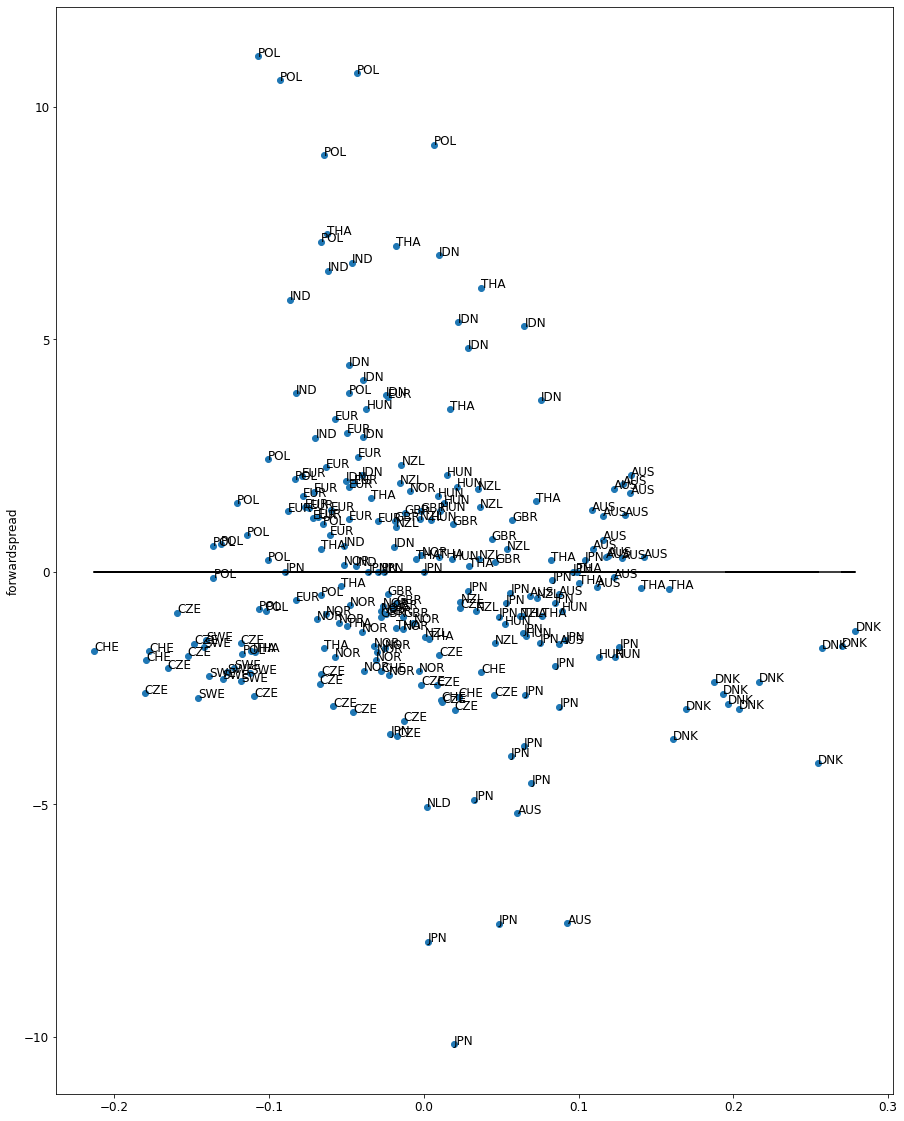

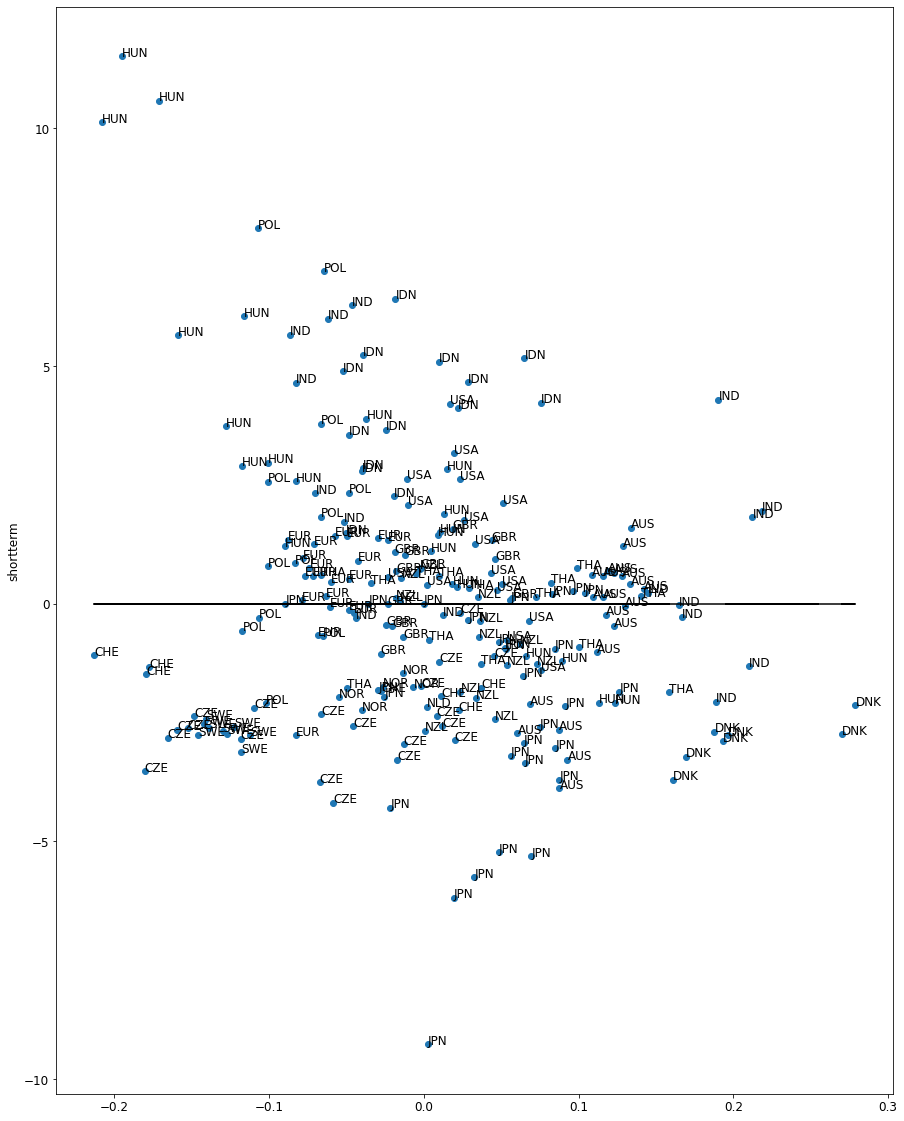

In [38]:
Xmod =PanelOLS(toreg[xvar],toreg[['constant','NGDP_share','cent_exp']],entity_effects=False,time_effects=True)
res = Xmod.fit(cov_type='clustered',cluster_entity=False)

toreg['Xresid'] = res.resids

Ymod = PanelOLS(toreg[yvar],toreg[['constant','NGDP_share','cent_exp']],entity_effects=False,time_effects=True)
res = Ymod.fit(cov_type='clustered',cluster_entity=False)
Ymod_y2 = PanelOLS(toreg[yvar2],toreg[['constant','NGDP_share','cent_exp']],entity_effects=False,time_effects=True)
res_y2 = Ymod_y2.fit(cov_type='clustered',cluster_entity=False)

toreg['Yresid'] = res.resids
toreg['Yresid_y2'] = res_y2.resids

plotScatter('Xresid','Yresid',toreg.reset_index(),"Currency Concentration",yvar)
plotScatter('Xresid','Yresid_y2',toreg.reset_index(),"Currency Concentration",yvar2)




/opt/anaconda3/lib/python3.9/site-packages/linearmodels/panel/model.py:1183: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/opt/anaconda3/lib/python3.9/site-packages/linearmodels/panel/model.py:1183: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/opt/anaconda3/lib/python3.9/site-packages/linearmodels/panel/model.py:1183: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


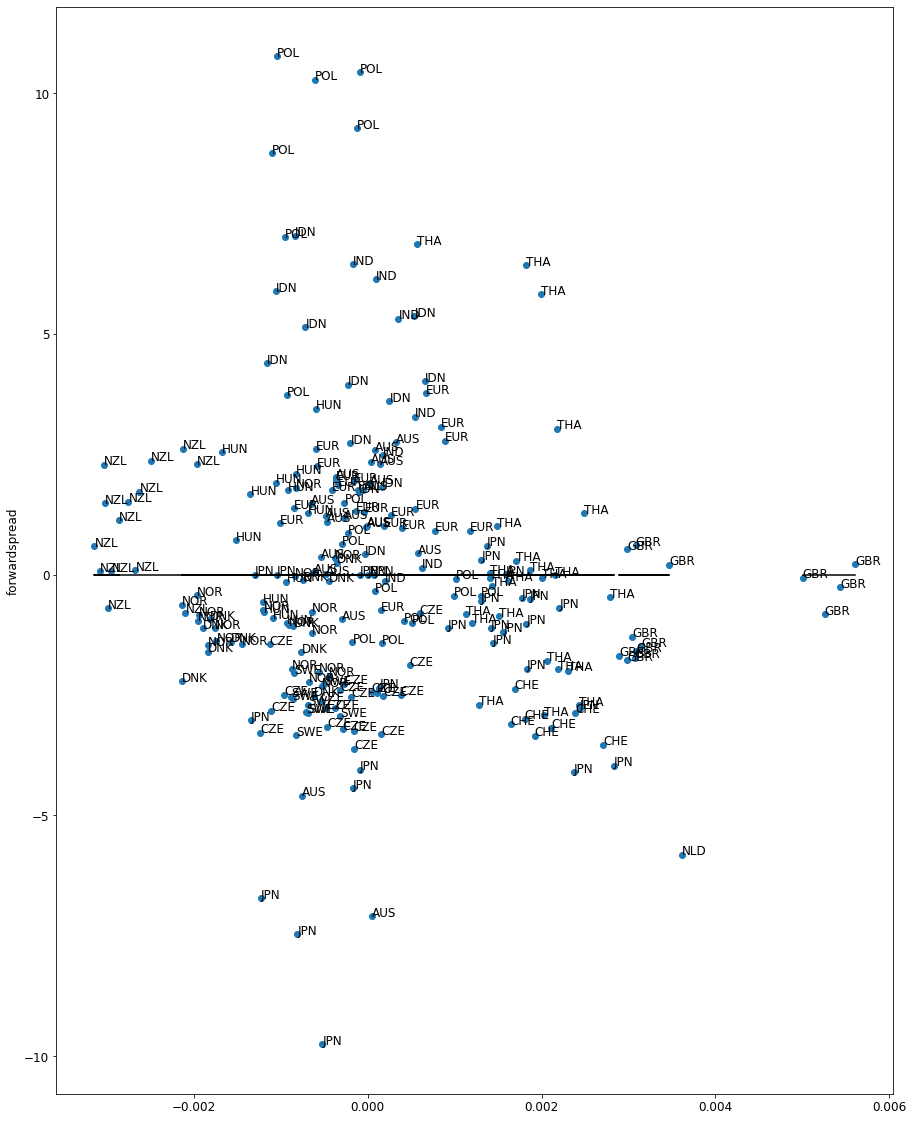

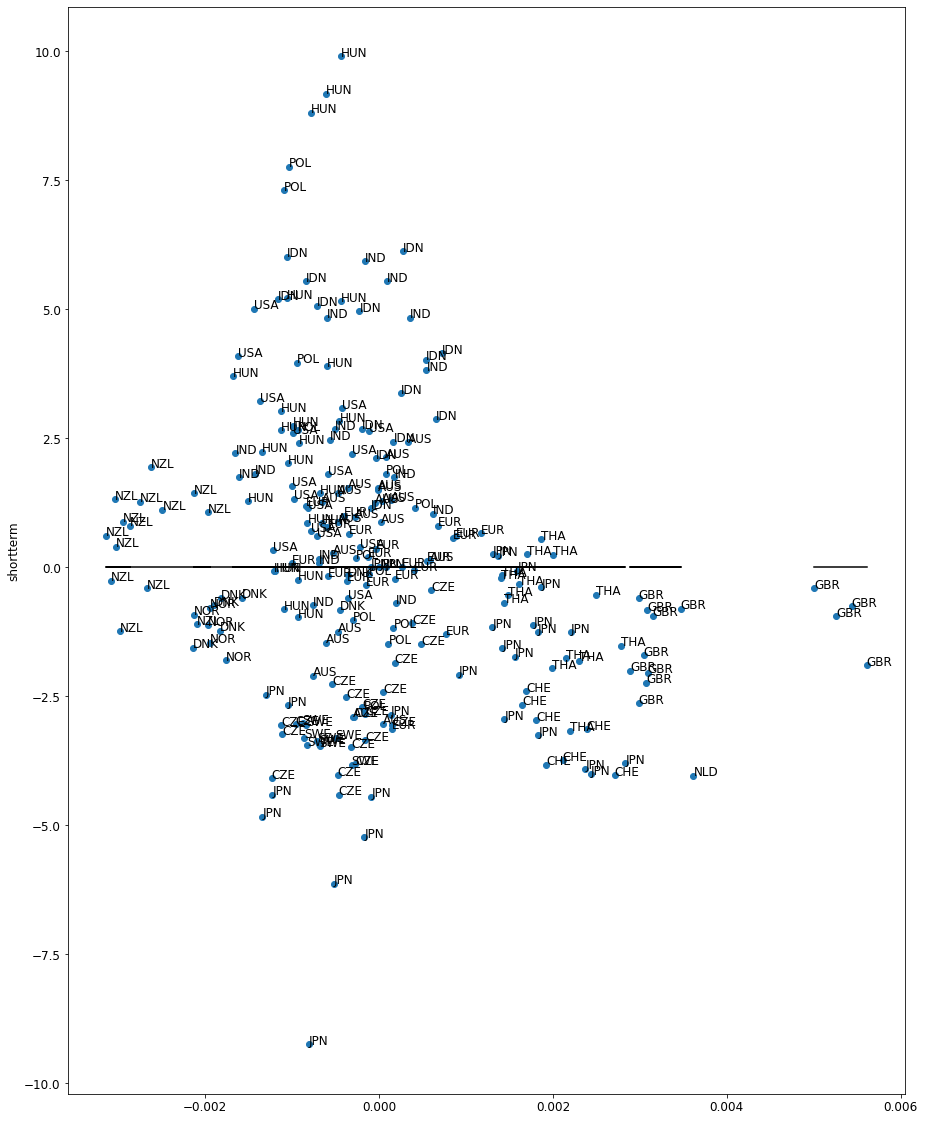

In [39]:
Xmod =PanelOLS(toreg['cent_exp'],toreg[['constant','NGDP_share',xvar]],entity_effects=False,time_effects=True)
res = Xmod.fit(cov_type='clustered',cluster_entity=False)

toreg['Xresid'] = res.resids

Ymod = PanelOLS(toreg[yvar],toreg[['constant','NGDP_share',xvar]],entity_effects=False,time_effects=True)
res = Ymod.fit(cov_type='clustered',cluster_entity=False)
Ymod_y2 = PanelOLS(toreg[yvar2],toreg[['constant','NGDP_share',xvar]],entity_effects=False,time_effects=True)
res_y2 = Ymod_y2.fit(cov_type='clustered',cluster_entity=False)

toreg['Yresid'] = res.resids
toreg['Yresid_y2'] = res_y2.resids

plotScatter('Xresid','Yresid',toreg.reset_index(),"Centrality",yvar)
plotScatter('Xresid','Yresid_y2',toreg.reset_index(),"Centrality",yvar2)



C:\Users\fuem\AppData\Roaming\Python\Python39\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\fuem\AppData\Roaming\Python\Python39\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\fuem\AppData\Roaming\Python\Python39\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


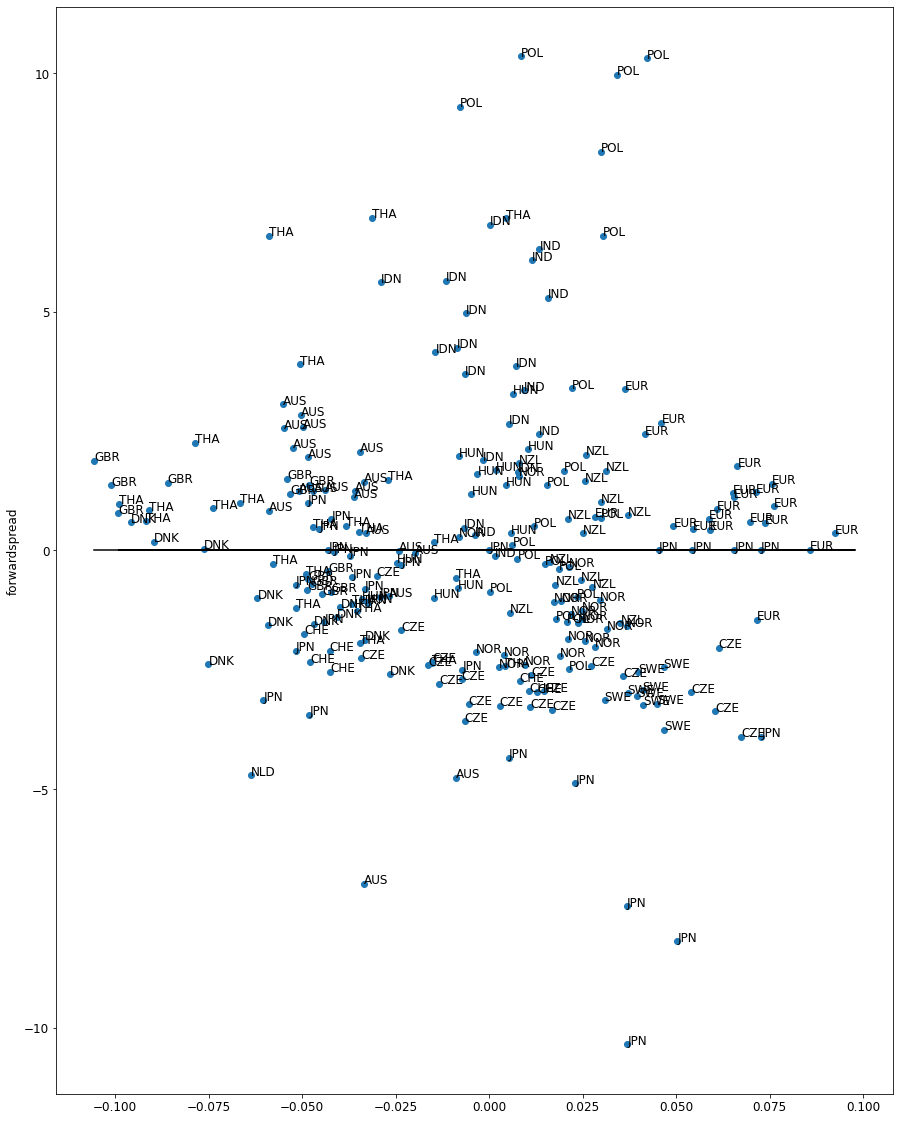

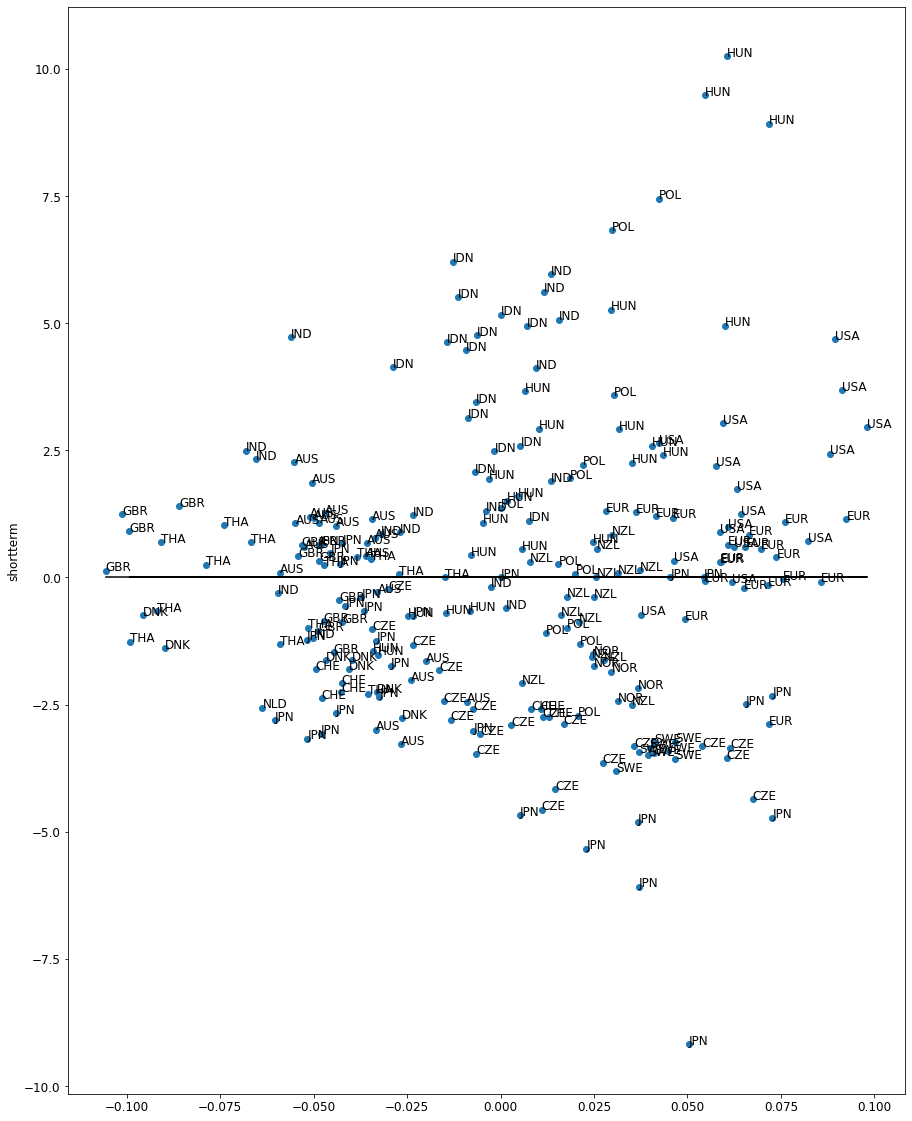

In [39]:
Xmod =PanelOLS(toreg['NGDP_share'],toreg[['constant','cent_exp',xvar]],entity_effects=False,time_effects=True)
res = Xmod.fit(cov_type='clustered',cluster_entity=False)

toreg['Xresid'] = res.resids

Ymod = PanelOLS(toreg[yvar],toreg[['constant','cent_exp',xvar]],entity_effects=False,time_effects=True)
res = Ymod.fit(cov_type='clustered',cluster_entity=False)
Ymod_y2 = PanelOLS(toreg[yvar2],toreg[['constant','cent_exp',xvar]],entity_effects=False,time_effects=True)
res_y2 = Ymod_y2.fit(cov_type='clustered',cluster_entity=False)

toreg['Yresid'] = res.resids
toreg['Yresid_y2'] = res_y2.resids

plotScatter('Xresid','Yresid',toreg.reset_index(),"NGDP share",yvar)
plotScatter('Xresid','Yresid_y2',toreg.reset_index(),"NGDP share",yvar2)


C:\Users\fuem\AppData\Roaming\Python\Python39\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\fuem\AppData\Roaming\Python\Python39\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\fuem\AppData\Roaming\Python\Python39\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


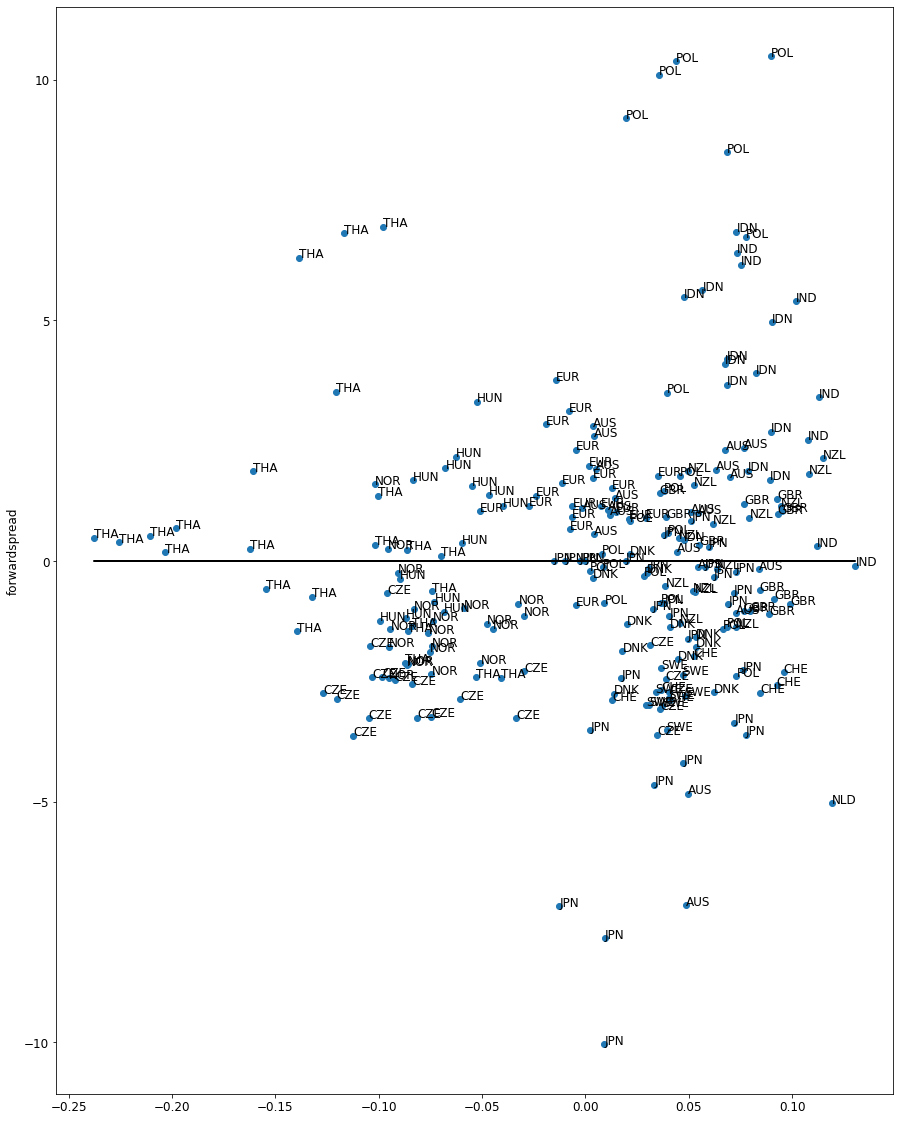

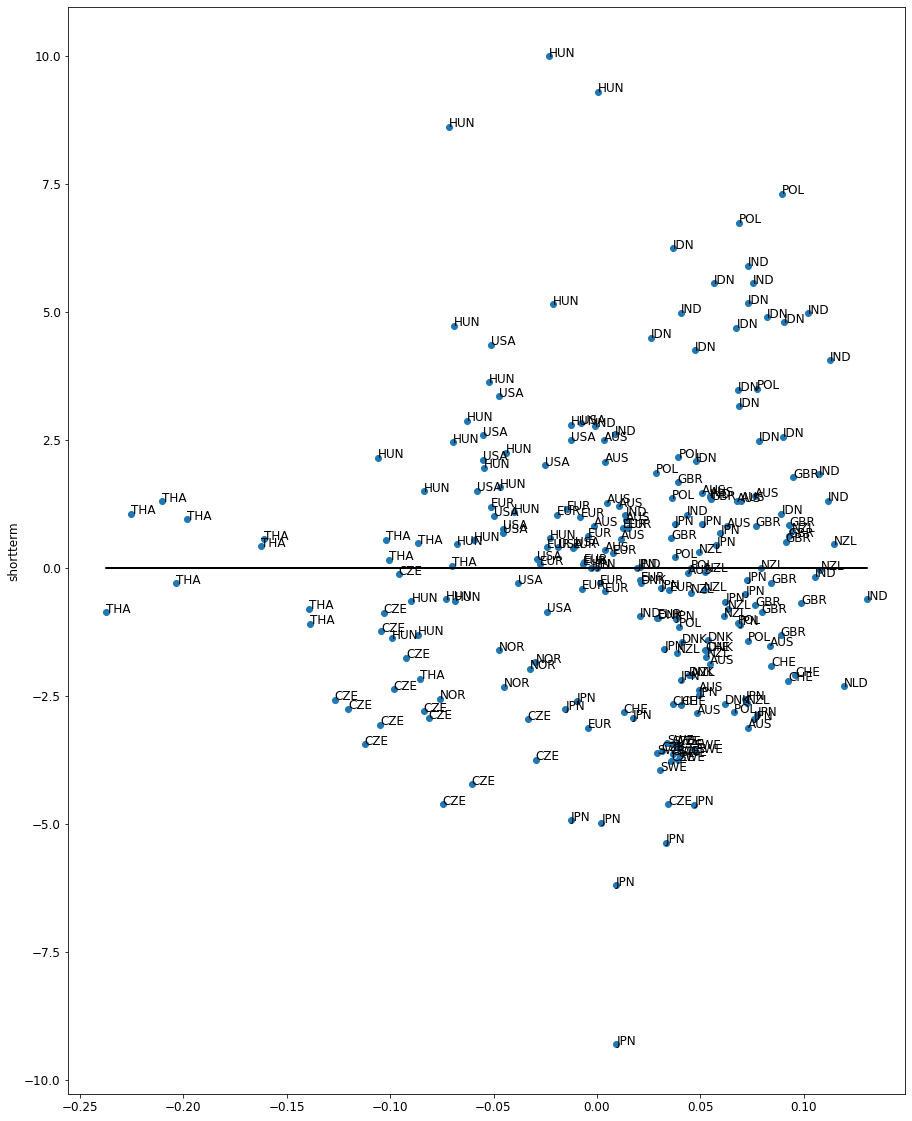

In [40]:
Xmod =PanelOLS(toreg['SumShares_X'],toreg[['constant','NGDP_share','cent_exp',xvar]],entity_effects=False,time_effects=True)
res = Xmod.fit(cov_type='clustered',cluster_entity=False)

toreg['Xresid'] = res.resids

Ymod = PanelOLS(toreg[yvar],toreg[['constant','NGDP_share','cent_exp',xvar]],entity_effects=False,time_effects=True)
res = Ymod.fit(cov_type='clustered',cluster_entity=False)
Ymod_y2 = PanelOLS(toreg[yvar2],toreg[['constant','NGDP_share','cent_exp',xvar]],entity_effects=False,time_effects=True)
res_y2 = Ymod_y2.fit(cov_type='clustered',cluster_entity=False)

toreg['Yresid'] = res.resids
toreg['Yresid_y2'] = res_y2.resids

plotScatter('Xresid','Yresid',toreg.reset_index(),"Currency Concentration",yvar)
plotScatter('Xresid','Yresid_y2',toreg.reset_index(),"Currency Concentration",yvar2)




C:\Users\fuem\AppData\Roaming\Python\Python39\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\fuem\AppData\Roaming\Python\Python39\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\fuem\AppData\Roaming\Python\Python39\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


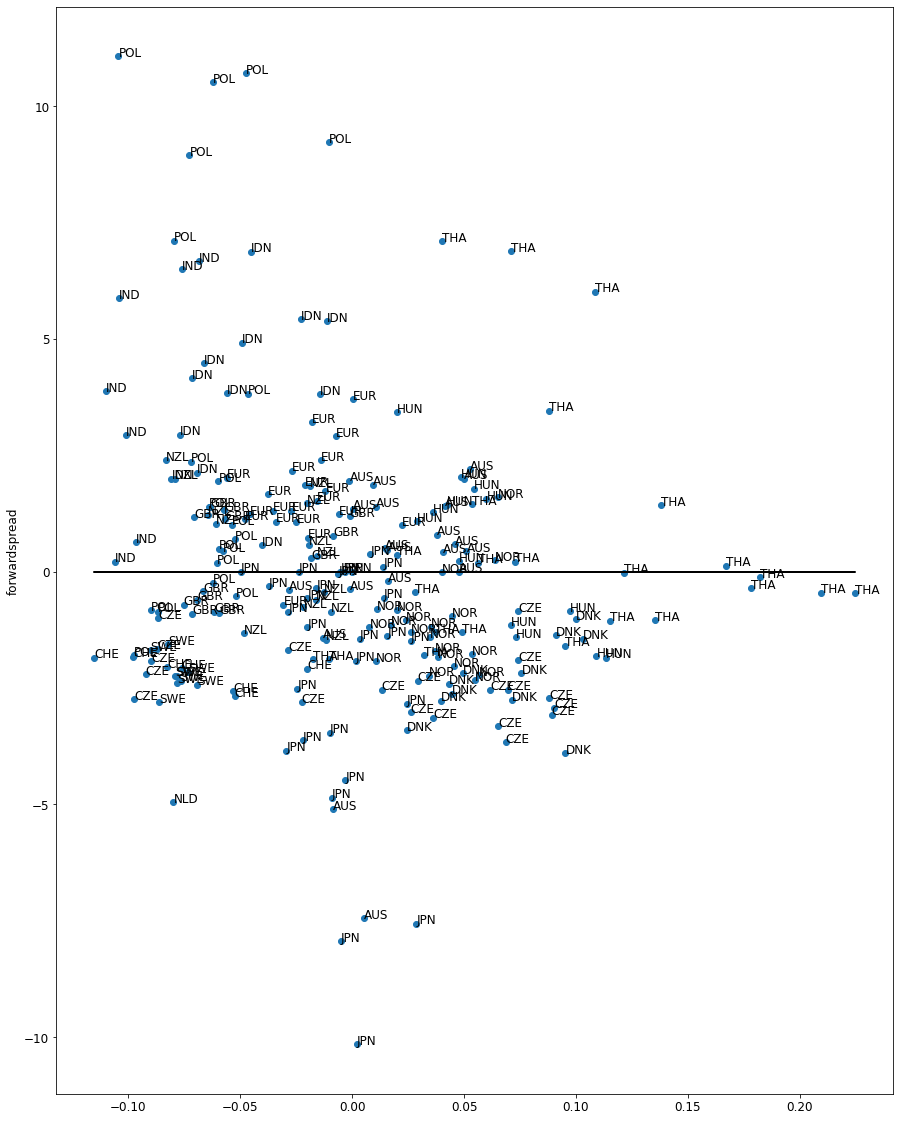

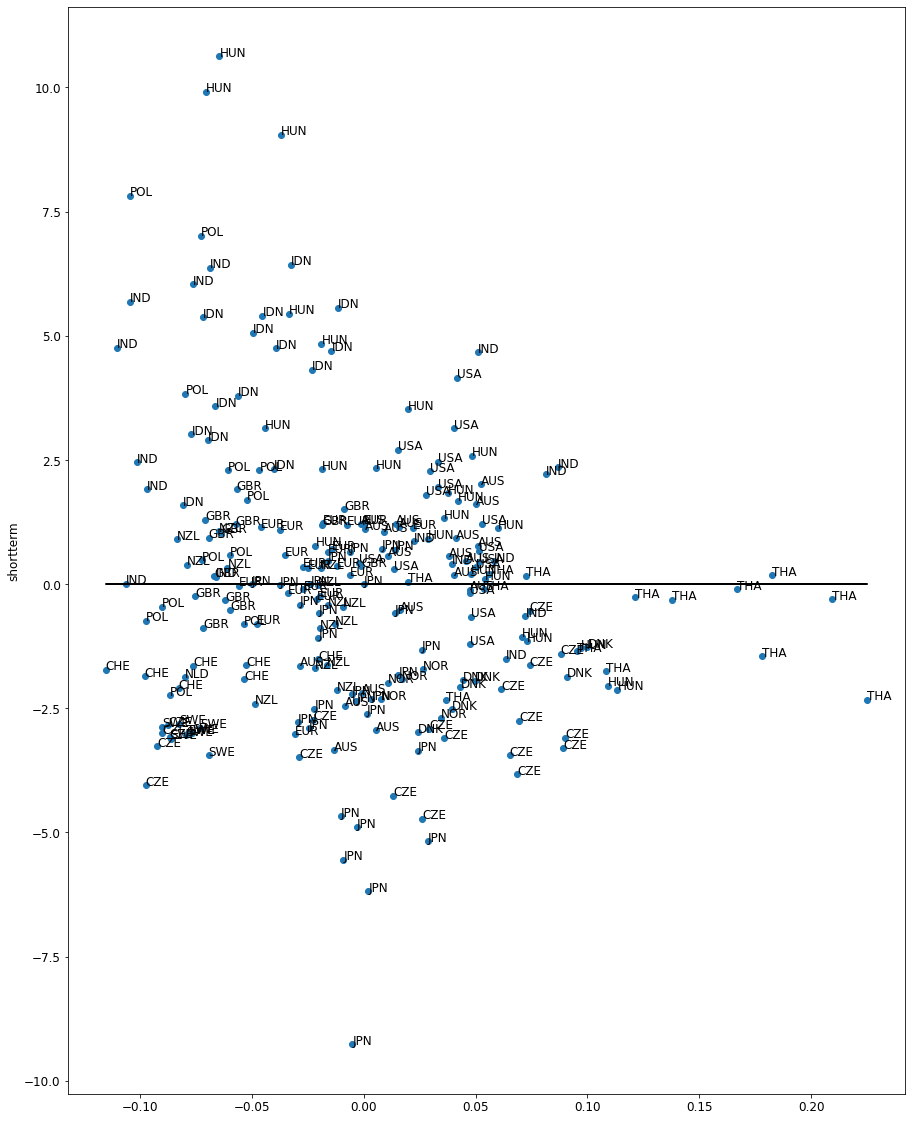

In [41]:
Xmod =PanelOLS(toreg[xvar],toreg[['constant','NGDP_share','cent_exp','SumShares_X']],entity_effects=False,time_effects=True)
res = Xmod.fit(cov_type='clustered',cluster_entity=False)

toreg['Xresid'] = res.resids

Ymod = PanelOLS(toreg[yvar],toreg[['constant','NGDP_share','cent_exp','SumShares_X']],entity_effects=False,time_effects=True)
res = Ymod.fit(cov_type='clustered',cluster_entity=False)
Ymod_y2 = PanelOLS(toreg[yvar2],toreg[['constant','NGDP_share','cent_exp','SumShares_X']],entity_effects=False,time_effects=True)
res_y2 = Ymod_y2.fit(cov_type='clustered',cluster_entity=False)

toreg['Yresid'] = res.resids
toreg['Yresid_y2'] = res_y2.resids

plotScatter('Xresid','Yresid',toreg.reset_index(),"Currency Concentration",yvar)
plotScatter('Xresid','Yresid_y2',toreg.reset_index(),"Currency Concentration",yvar2)

In [59]:
df[df['Country']=='New Zealand'].groupby('Decade').mean()




,year,imfcode,Import USD_I,Import EUR_I,Import Home_I,Import USD,Import EUR,Import Home,Export USD_I,Export EUR_I,...,impshare,consrs_pwt,policyrate,shortterm,month,EU_GDP_USD,EU_GDP_EUR,ImportUSD_sum,ImportEUR_sum,NGDP_share
Decade,,,,,,,,,,,,,,,,,,,,,
1980.0,1986.000000,196.0,12.989302,2.255585,71.591011,NaN,NaN,NaN,10.567087,2.957933,...,0.003094,0.558651,NaN,NaN,6.5,0.002245,0.002245,NaN,NaN,NaN
1990.0,1994.500000,196.0,14.348428,2.411820,71.805171,NaN,NaN,NaN,13.049338,2.715540,...,0.002520,0.289126,4.600000,8.180083,6.5,0.002128,0.002128,NaN,NaN,NaN
2000.0,2004.500000,196.0,18.021147,2.990345,68.409271,18.083355,3.016618,69.168757,15.895191,2.420399,...,0.002423,0.146765,6.070833,6.353000,6.5,0.003855,0.003855,NaN,NaN,0.002520
2010.0,2014.500000,196.0,17.676977,2.735132,70.916843,17.768691,2.774139,71.065603,16.733385,1.618820,...,0.002250,0.380828,2.366667,2.554750,6.5,0.004633,0.004633,NaN,NaN,0.003274
2020.0,2021.153846,196.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.364583,0.485000,6.153846,0.002451,0.002451,NaN,NaN,NaN


In [60]:
df[df['Country']=='Russia'].groupby('year').mean()

,imfcode,Import USD_I,Import EUR_I,Import Home_I,Import USD,Import EUR,Import Home,Export USD_I,Export EUR_I,Export Home_I,...,consrs_pwt,policyrate,shortterm,month,EU_GDP_USD,EU_GDP_EUR,ImportUSD_sum,ImportEUR_sum,Decade,NGDP_share
year,,,,,,,,,,,,,,,,,,,,,


In [61]:
df[df['Country']=='India'].groupby('Decade').mean()

,year,imfcode,Import USD_I,Import EUR_I,Import Home_I,Import USD,Import EUR,Import Home,Export USD_I,Export EUR_I,...,impshare,consrs_pwt,policyrate,shortterm,month,EU_GDP_USD,EU_GDP_EUR,ImportUSD_sum,ImportEUR_sum,NGDP_share
Decade,,,,,,,,,,,,,,,,,,,,,
1980.0,1986.000000,534.0,6.138612,2.069663,91.797627,NaN,NaN,NaN,0.041161,0.007815,...,0.008419,0.593548,NaN,NaN,6.5,0.017942,0.017942,NaN,NaN,NaN
1990.0,1994.500000,534.0,10.816566,2.591015,86.601758,11.379112,0.000000,88.620888,7.172275,1.059321,...,0.007139,0.442466,NaN,9.291012,6.5,0.052525,0.052525,NaN,NaN,0.014099
2000.0,2004.500000,534.0,23.406824,3.433603,63.259573,27.851075,3.276599,68.872326,15.529328,1.756998,...,0.016445,0.488426,6.990476,6.247350,6.5,0.029849,0.029849,NaN,NaN,0.020756
2010.0,2014.500000,534.0,37.794426,3.896210,58.309364,37.163108,3.830635,59.006258,21.131488,1.893793,...,0.027592,0.613070,6.860417,7.205634,6.5,0.049046,0.049046,NaN,NaN,0.033034
2020.0,2021.153846,534.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.129167,3.567713,6.153846,0.031562,0.031562,NaN,NaN,NaN


In [62]:
df[df['Country']=='Indonesia'].groupby('Decade').mean()

,year,imfcode,Import USD_I,Import EUR_I,Import Home_I,Import USD,Import EUR,Import Home,Export USD_I,Export EUR_I,...,impshare,consrs_pwt,policyrate,shortterm,month,EU_GDP_USD,EU_GDP_EUR,ImportUSD_sum,ImportEUR_sum,NGDP_share
Decade,,,,,,,,,,,,,,,,,,,,,
1980.0,1986.000000,536.0,0.233117,0.029146,0.666892,NaN,NaN,NaN,22.696909,0.467779,...,0.005031,-1.409235,NaN,NaN,6.5,0.006040,0.006040,NaN,NaN,NaN
1990.0,1994.500000,536.0,0.295885,0.031209,0.597871,30.470591,3.192099,66.337310,25.911394,0.473350,...,0.006370,0.587342,18.701833,NaN,6.5,0.024081,0.024081,NaN,NaN,0.006496
2000.0,2004.500000,536.0,15.614026,0.579710,32.003836,30.813142,1.614610,65.301463,30.256588,0.508908,...,0.008034,0.923087,10.686750,9.774622,6.5,0.013698,0.013698,NaN,NaN,0.007202
2010.0,2014.500000,536.0,26.476856,1.268120,67.667674,26.476856,1.268120,67.667674,20.942817,0.242244,...,0.011095,-0.119202,6.127083,6.615406,6.5,0.022100,0.022100,NaN,NaN,0.016073
2020.0,2021.153846,536.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.885417,4.237475,6.153846,0.012232,0.012232,NaN,NaN,NaN


# Motivation Plot with time series of HK/Other Exchange Rates

In [63]:
df_c = df_b.groupby(['iso3','year','month']).mean().reset_index()

df_HK = df_c[df_c['iso3']=='HKG'][['iso3','year','month','spot','gdp']]

df_HK.rename(columns={'spot':'HK_spot','gdp':'HKGDP'},inplace=True)



df_HK['HKGDP_l']=df_HK['HKGDP'].shift(1)
df_HK['HKGDP_pct'] = (df_HK['HKGDP']-df_HK['HKGDP_l'])/df_HK['HKGDP_l']
df_HK.drop(columns=['HKGDP_l','HKGDP','iso3'],inplace=True)

df_c = pd.merge(df_c,df_HK,on=['year','month'],how='left')

df_c['Spot_HK']=df_c['spot']/df_c['HK_spot']

# Make beginning of period exchange rate 100
dd = df_c[(df_c['year']==2008)&(df_c['month']==6)][['iso3','Spot_HK']]
dd.rename(columns={'Spot_HK':'firstSpot'},inplace=True)
df_c = pd.merge(df_c,dd,on='iso3',how='left')
#df_c['firstSpot']=df_c.groupby(['iso3'])['Spot_HK'].transform('first')
df_c['Spot_HK'] = df_c['Spot_HK']/df_c['firstSpot']*100
df_c['Day']=1
df_c['Date']=pd.to_datetime(df_c[['year', 'month','Day']])

In [74]:
df_c

,iso3,year,month,imfcode,Import USD_I,Import EUR_I,Import Home_I,Import USD,Import EUR,Import Home,...,EU_GDP_USD,EU_GDP_EUR,ImportUSD_sum,ImportEUR_sum,HK_spot,HKGDP_pct,Spot_HK,firstSpot,Day,Date
0,AGO,1983,1.0,614.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000538,0.000538,NaN,NaN,NaN,NaN,NaN,NaN,1,1983-01-01
1,AGO,1983,2.0,614.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000538,0.000538,NaN,NaN,NaN,NaN,NaN,NaN,1,1983-02-01
2,AGO,1983,3.0,614.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000538,0.000538,NaN,NaN,NaN,NaN,NaN,NaN,1,1983-03-01
3,AGO,1983,4.0,614.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000538,0.000538,NaN,NaN,NaN,NaN,NaN,NaN,1,1983-04-01
4,AGO,1983,5.0,614.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000538,0.000538,NaN,NaN,NaN,NaN,NaN,NaN,1,1983-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57925,ZMB,2021,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000214,0.000214,NaN,NaN,7.77745,NaN,NaN,NaN,1,2021-08-01
57926,ZMB,2021,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000214,0.000214,NaN,NaN,7.78610,NaN,NaN,NaN,1,2021-09-01
57927,ZMB,2021,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000214,0.000214,NaN,NaN,7.77890,NaN,NaN,NaN,1,2021-10-01
57928,ZMB,2021,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000214,0.000214,NaN,NaN,7.79745,NaN,NaN,NaN,1,2021-11-01


C:\Users\fuem\AppData\Local\Temp\ipykernel_13480\1392146630.py:16: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ax.axvline(pd.datetime(2008, 6, 1),color='black')
C:\Users\fuem\AppData\Local\Temp\ipykernel_13480\1392146630.py:17: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ax.axvline(pd.datetime(2020, 1, 1),color='black')
C:\Users\fuem\AppData\Local\Temp\ipykernel_13480\1392146630.py:18: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ax.axvline(pd.datetime(2000, 3, 1),color='black')
C:\Users\fuem\AppData\Local\Temp\ipykernel_13480\1392146630.py:21: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module inste

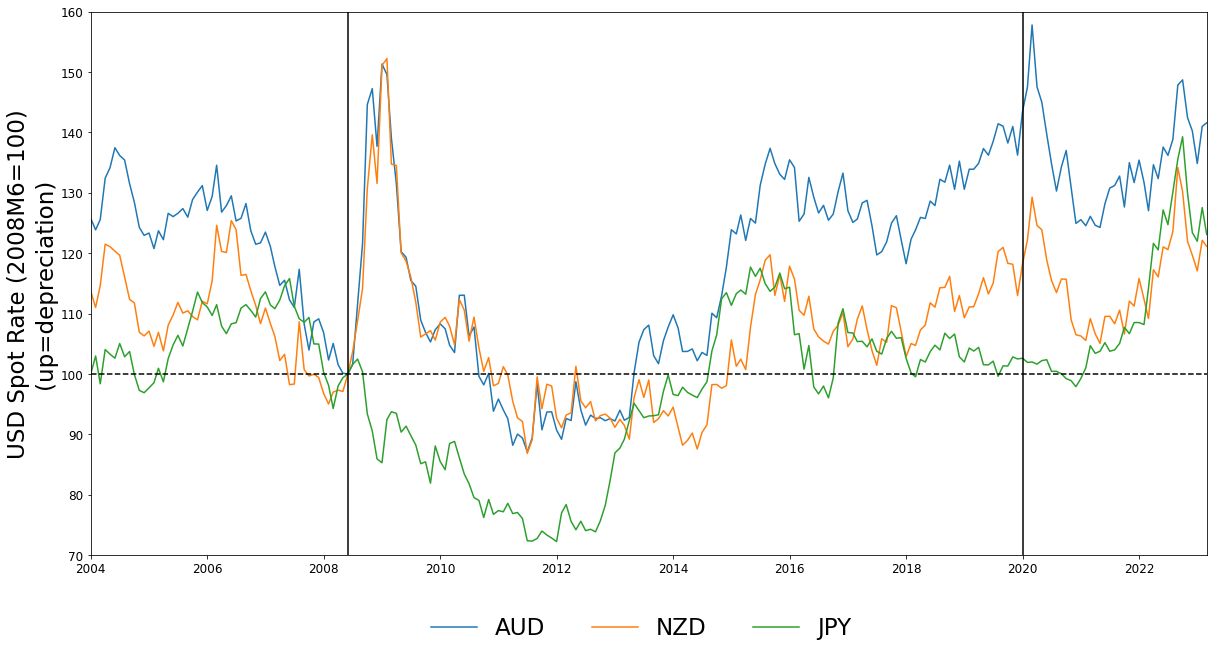

In [64]:

countryList = ['AUS','NZL','JPN']
countryNames = ['AUD','NZD','JPY']

fig,ax=plt.subplots(figsize=(20,10))

for c in countryList:
    index = df_c['iso3']==c
    nam = countryNames[countryList.index(c)]
    ax.plot(df_c[index]['Date'],df_c[index]['Spot_HK'],label=nam)
#index2 = df_c['iso3']=='JPN'
#ax.plot(df_c[index2]['Date'],df_c[index2]['Spot_HK'])
#index3 = df_c['iso3']=='NZL'
#ax.plot(df_c[index3]['Date'],df_c[index3]['Spot_HK'])
#index4 = df_c['iso3']=='CHE'
#ax.plot(df_c[index4]['Date'],df_c[index4]['Spot_HK'])
ax.axvline(pd.datetime(2008, 6, 1),color='black')
ax.axvline(pd.datetime(2020, 1, 1),color='black')
ax.axvline(pd.datetime(2000, 3, 1),color='black')
ax.axhline(100,color='black',linestyle='dashed')
ax.legend(bbox_to_anchor=(0.7,-0.075),ncol=len(countryList),fontsize=23,frameon=False)
ax.set_xlim([pd.datetime(2004, 1, 1), pd.datetime(2023, 3, 1)])
ax.set_ylabel('USD Spot Rate (2008M6=100)\n(up=depreciation)',fontsize=23)
ax.set_ylim([70,160])
plt.show()

fig.savefig(path_saveFig+'ExchangeRateProperties'+'.pdf')

In [71]:
df_c[df_c['iso3'].isin(countryList)]

,iso3,year,month,imfcode,Import USD_I,Import EUR_I,Import Home_I,Import USD,Import EUR,Import Home,...,EU_GDP_USD,EU_GDP_EUR,ImportUSD_sum,ImportEUR_sum,HK_spot,HKGDP_pct,Spot_HK,firstSpot,Day,Date
2415,AUS,1983,1.0,193.0,8.914213,0.476887,84.94317,NaN,NaN,NaN,...,0.016475,0.016475,NaN,NaN,NaN,NaN,NaN,0.134026,1,1983-01-01
2416,AUS,1983,2.0,193.0,8.914213,0.476887,84.94317,NaN,NaN,NaN,...,0.016475,0.016475,NaN,NaN,NaN,NaN,NaN,0.134026,1,1983-02-01
2417,AUS,1983,3.0,193.0,8.914213,0.476887,84.94317,NaN,NaN,NaN,...,0.016475,0.016475,NaN,NaN,NaN,NaN,NaN,0.134026,1,1983-03-01
2418,AUS,1983,4.0,193.0,8.914213,0.476887,84.94317,NaN,NaN,NaN,...,0.016475,0.016475,NaN,NaN,NaN,NaN,NaN,0.134026,1,1983-04-01
2419,AUS,1983,5.0,193.0,8.914213,0.476887,84.94317,NaN,NaN,NaN,...,0.016475,0.016475,NaN,NaN,NaN,NaN,NaN,0.134026,1,1983-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41230,NZL,2022,11.0,196.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.002546,0.002546,NaN,NaN,7.80985,NaN,121.950852,0.168455,1,2022-11-01
41231,NZL,2022,12.0,196.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.002546,0.002546,NaN,NaN,7.80965,NaN,119.658406,0.168455,1,2022-12-01
41232,NZL,2023,1.0,196.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,7.84050,NaN,117.060048,0.168455,1,2023-01-01
41233,NZL,2023,2.0,196.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,7.84935,NaN,122.123691,0.168455,1,2023-02-01


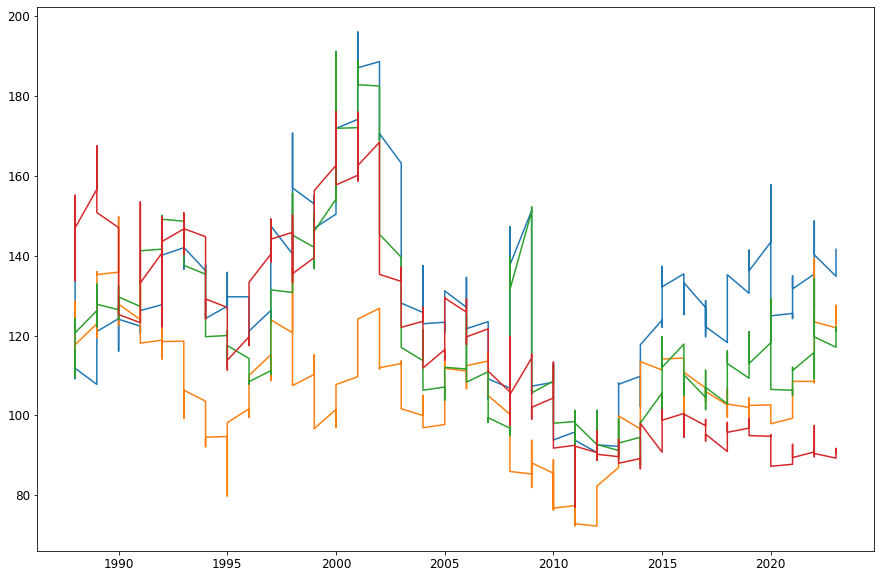

In [66]:

fig,ax=plt.subplots(figsize=(15,10))
index = df_c['iso3']=='AUS'
ax.plot(df_c[index]['year'],df_c[index]['Spot_HK'])
index2 = df_c['iso3']=='JPN'
ax.plot(df_c[index2]['year'],df_c[index2]['Spot_HK'])
index3 = df_c['iso3']=='NZL'
ax.plot(df_c[index3]['year'],df_c[index3]['Spot_HK'])
index4 = df_c['iso3']=='CHE'
ax.plot(df_c[index4]['year'],df_c[index4]['Spot_HK'])

plt.show()

In [73]:
df_c[index]['Spot_HK']

2415           NaN
2416           NaN
2417           NaN
2418           NaN
2419           NaN
           ...    
2893    142.416148
2894    140.231955
2895    134.836390
2896    140.977049
2897    141.575806
Name: Spot_HK, Length: 483, dtype: float64

In [69]:
df_c[df_c['iso3']=='NZL'][['spot','Spot_HK']]

,spot,Spot_HK
40752,NaN,NaN
40753,NaN,NaN
40754,NaN,NaN
40755,NaN,NaN
40756,NaN,NaN
...,...,...
41230,1.6044,121.950852
41231,1.5742,119.658406
41232,1.5461,117.060048
41233,1.6148,122.123691
